# IBM Data Science Capstone Project: 
# Predicting Ohio Presidential Voting 

## Introduction

In the 2016 U.S. Presidential election, Donald J. Trump won the electoral college vote (although he lost the popular vote). Despite the popularly held convention that he couldn't win, and was behind in most predictive polls, he did manage a clear electoral college victory. Some have said that the media and people on the left of the political spectrum just did not want to believe that Trump could possibly win, and therefore ignored what was evident in the statistical polling data. However, the polls really did show a strong preference for Clinton over Trump. It's unclear as to why the polls were so wrong, but begs the question: are there other ways to explain the way a state, district, or precinct votes?

In theory, the President of the United States makes policy and guides the nation in tangible and intangible ways. Therefore, the mechanics of how the U.S. electorate votes for the President has consequences for everyone. There are innumerable ways to do this. The Economist's article on forecasting an American's vote (https://www.economist.com/graphic-detail/2018/11/03/how-to-forecast-an-americans-vote) compares voter charactertistcs, and found that religion was the single best predictor of voting preferences. The model found that religion could accurately predict a preference for Democratic voting about 87% of the time and a preference for Republican voting about 80% of the time. Other characterstics included *race*, *sexual orientation*, *education*, *age*, *gender*, etc. *Region* and *population density* were also included, both with average predictions in the 50%-60% accuracy range.

The hypothesis of this work is that the rural or urban nature of a region has a predictive power much greater than the *region* and *population density* characteristics in The Economist's model. Therefore, the stereotype that rural areas vote Republican and urban areas vote Democrat will be explored in more detail by quantifying a region's *rural*ness or *urban*ness by using the the venues, businesses, and services in that region. The result will be a model that predicts how an Ohio voting precinct will vote based solely on the venues, businesses, and services available to that precinct.

## Data Acquisition, Cleaning & Exploration

In order to make the problem of "rural" versus "urban" voting preferences more manageable, the focus has been narrowed from the whole country down to the swing-state of Ohio only. To do the analysis, three different sets of data: (1) Ohio precinct-level raw vote counts; (2) Ohio precinct shapes/boundaries in latitude/longitude format; and, (3) some sort of data reflecting the rural or urban nature of the precinct. The United States Census Bureau states that the *"urban-rural classification is fundamentally a delineation of geographical areas...  The Census Bureau’s urban areas represent densely developed territory, and encompass residential, commercial, and other non-residential urban land uses... The Census Bureau identifies two types of urban areas:*

- *Urbanized Areas (UAs) of 50,000 or more people;*
- *Urban Clusters (UCs) of at least 2,500 and less than 50,000 people.*

*'Rural' encompasses all population, housing, and territory not included within an urban area."*

In this work, the definitions of rural and urban areas go beyond the delineation by "densely developed territory" and examines the actual commercial and non-residential development itself. 

#### Data: Precinct shapes & raw vote counts

It was a shock to realize that raw precinct-level voting data information is not publicly available from state or federal agencies. In fact, only aggregated voting district counts (districts are made up of precincts) are available. After much online sleuthing, the data was obtained from the Metric Geometry and Gerrymandering Group (MGGG). The main goal of the MGGG is actually to "find out what type of data \[they\] could obtain from the individual counties in Ohio on their precinct boundaries, and to work towards turning that into a unified statewide shapefile." Luckily, for the purposes of this work, the group just happens to also include raw precinct-level vote counts in their dataset. Available from their GitHub repository (https://github.com/mggg/ohio-precincts), the MGGG provides a GeoPandas (http://geopandas.org) geopackage shape file containing raw votes and shape coordinates for each precinct. They were not able to develop only a handful of precincts, and so, these are not included in the analysis that follows.

So, an examination of this GeoPandas data follows below:

In [2]:
# import libraries
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [3]:
# adjust pandas display properties
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 40) # had to limit for readability w/ polygon values

In [4]:
# read in the manually downloaded geopackage data file (GitHub link above)
precincts_gdf = gpd.read_file("precincts_results.gpkg")

In [5]:
# check it out
print(precincts_gdf.shape)
print(precincts_gdf.columns)
precincts_gdf.head()

(10592, 38)
Index(['PRECINCT', 'COUNTY', 'global_id', 'COUNTYGEOID10',
       'PRECINCT_election_results', 'PRECINCTCODE_election_results',
       'PRECINCT_misfit', 'county_name', 'precinct_code', 'region_name',
       'media_market', 'pres_16_registered_voters', 'pres_16_total_voters',
       'pres_16_turnout_percentage', 'pres_16_james_jerome_bell_wi',
       'pres_16_michael_bickelmeyer_wi', 'pres_16_darrell_l_castle_wi',
       'pres_16_hillary_clinton_d', 'pres_16_richard_duncan',
       'pres_16_cherunda_fox_wi', 'pres_16_ben_hartnell_wi',
       'pres_16_tom_hoefling_wi', 'pres_16_bruce_e_jaynes_wi',
       'pres_16_gary_johnson', 'pres_16_chris_keniston_wi',
       'pres_16_barry_kirschner_wi', 'pres_16_laurence_kotlikoff_wi',
       'pres_16_joseph_maldonado_wi', 'pres_16_michael_andrew_maturen_wi',
       'pres_16_evan_mc_mullin_wi', 'pres_16_monica_moorehead_wi',
       'pres_16_joe_schriner_wi', 'pres_16_mike_smith_wi',
       'pres_16_jill_stein_g', 'pres_16_josiah_r_stro

,PRECINCT,COUNTY,global_id,COUNTYGEOID10,PRECINCT_election_results,PRECINCTCODE_election_results,PRECINCT_misfit,county_name,precinct_code,region_name,media_market,pres_16_registered_voters,pres_16_total_voters,pres_16_turnout_percentage,pres_16_james_jerome_bell_wi,pres_16_michael_bickelmeyer_wi,pres_16_darrell_l_castle_wi,pres_16_hillary_clinton_d,pres_16_richard_duncan,pres_16_cherunda_fox_wi,pres_16_ben_hartnell_wi,pres_16_tom_hoefling_wi,pres_16_bruce_e_jaynes_wi,pres_16_gary_johnson,pres_16_chris_keniston_wi,pres_16_barry_kirschner_wi,pres_16_laurence_kotlikoff_wi,pres_16_joseph_maldonado_wi,pres_16_michael_andrew_maturen_wi,pres_16_evan_mc_mullin_wi,pres_16_monica_moorehead_wi,pres_16_joe_schriner_wi,pres_16_mike_smith_wi,pres_16_jill_stein_g,pres_16_josiah_r_stroh_wi,pres_16_douglas_w_thomson_wi,pres_16_donald_j_trump_r,geometry
0,GALLIPOLIS CITY 1,gallia,4179.0,39053.0,GALLIPOLIS CITY 1,AAA,None,Gallia,AAA,Southeast,Charleston,601.0,386.0,64.23,0.0,0.0,0.0,100.0,2.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,267.0,(POLYGON ((394208.1309668442 4296804...
1,GALLIPOLIS CITY 3,gallia,4180.0,39053.0,GALLIPOLIS CITY 3,AAB,None,Gallia,AAB,Southeast,Charleston,1113.0,675.0,60.65,0.0,0.0,0.0,177.0,5.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,449.0,(POLYGON ((399776.4066106104 4299391...
2,GALLIPOLIS CITY 2,gallia,4181.0,39053.0,GALLIPOLIS CITY 2,AAE,None,Gallia,AAE,Southeast,Charleston,582.0,393.0,67.53,0.0,0.0,0.0,113.0,3.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,247.0,(POLYGON ((395684.3247016144 4297527...
3,ADDISON TOWNSHIP,gallia,4182.0,39053.0,ADDISON TWP,AAG,None,Gallia,AAG,Southeast,Charleston,1357.0,984.0,72.51,0.0,0.0,0.0,167.0,12.0,0.0,0.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,752.0,(POLYGON ((399263.2164539802 4309896...
4,CHESHIRE TOWNSHIP,gallia,4183.0,39053.0,CHESHIRE TWP,AAI,None,Gallia,AAI,Southeast,Charleston,616.0,429.0,69.64,0.0,0.0,0.0,81.0,4.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,330.0,(POLYGON ((394490.6016695436 4310216...


The first and second data sets we require for the proposed analysis are in this dataset. Each row contains precinct indentification information, followed by raw vote counts, and the final column contains the geopackage precinct shape data. The geopackage shape data provides location data to define the boundaries of each precinct. In the following section, venue (restaurants, stores, etc.) data will be acquired for each precinct. In order to do this, a central location data point for each precinct is needed. Therefore, the geometric centroid for each precinct centroid is calculated using the precinct boundary data. (GeoPandas has a built-in function to calculate the centroids, which is used here.)

In [6]:
# convert geocoding to classic lat/long (need for calls to Foursquare)
print("Original Coordinate Reference System (CRS): ",precincts_gdf.crs)
precincts_gdf = precincts_gdf.to_crs(epsg=4326)
print("NEW Coordinate Reference System (CRS):      ",precincts_gdf.crs)

Original Coordinate Reference System (CRS):  {'init': 'epsg:2958'}
NEW Coordinate Reference System (CRS):       {'init': 'epsg:4326', 'no_defs': True}


To make sure this has been done correctly, the following code identifies a small sample of precincts which contain 'Napoleon' in the name, and plots the corresponding precincts with their newly calculated centroids.

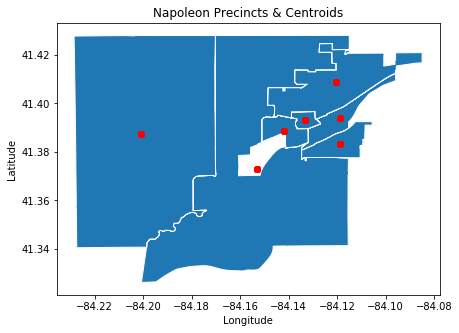

In [7]:
# look at only precincts that make up the *Napoleon* group of precincts
Napoleon_df = precincts_gdf[precincts_gdf["PRECINCT"]=='Napoleon'].copy()

# allocate empty lists for latitude and longitude of each of these precincts
Nap_lon = []
Nap_lat = []

# loop over all precincts Napoleon & calculate lat/lon using GeoPandas built-in method
for i in range(0,Napoleon_df.shape[0]):
    lon = Napoleon_df.iloc[i]["geometry"].centroid.coords[0][0]
    lat = Napoleon_df.iloc[i]["geometry"].centroid.coords[0][1]
    #print(lon, lat)
    Nap_lon.append(lon)
    Nap_lat.append(lat)
    
# convert lists to dataframes
Nap_lon_df = pd.DataFrame(Nap_lon)
Nap_lat_df = pd.DataFrame(Nap_lat)

# reset row indices (index) so that index matches on columns to be added
Napoleon_df.reset_index(inplace=True)

# add lon/lat columns to original Napoleon_df dataframe to plot
Napoleon_df["centroid_lon"] = Nap_lon_df
Napoleon_df["centroid_lat"] = Nap_lat_df

# plot Napoleon precincts
fig = Napoleon_df.plot(figsize=[7,5], edgecolor='white')

# plot centroid of each Napoleon precincts
for i in range(0,Napoleon_df.shape[0]):
        
    plt.scatter(Napoleon_df.iloc[i]["centroid_lon"], 
                Napoleon_df.iloc[i]["centroid_lat"], 
                color='r')
    
fig.set_title('Napoleon Precincts & Centroids')
fig.set_xlabel('Longitude')
fig.set_ylabel('Latitude')

# save to file
plt.savefig('1_precinct_centroids.png')

plt.show()

### Counties in 12th

Ohio's 12th congressional district is a United States congressional district in central Ohio, covering Delaware County, Morrow County, and Licking County, along with parts of Franklin, Marion, Muskingum, and Richland counties.[4] The district includes communities north and east of Columbus including Zanesville, Mansfield, and Dublin.

In [26]:
import numpy as np

In [70]:
counties = precincts_gdf["COUNTY"]

In [71]:
print(type(counties))
print(counties.shape)

<class 'pandas.core.series.Series'>
(10592,)


In [72]:
counties

0            gallia
1            gallia
2            gallia
3            gallia
4            gallia
5            gallia
6            gallia
7            gallia
8            gallia
9            gallia
10           gallia
11           gallia
12           gallia
13           gallia
14           gallia
15           gallia
16           gallia
17           gallia
18           gallia
19           gallia
20           gallia
21           gallia
22           gallia
23           gallia
24           gallia
25        fairfield
26        fairfield
27        fairfield
28        fairfield
29        fairfield
30        fairfield
31        fairfield
32        fairfield
33        fairfield
34        fairfield
35        fairfield
36        fairfield
37        fairfield
38        fairfield
39        fairfield
40        fairfield
41        fairfield
42        fairfield
43        fairfield
44        fairfield
45        fairfield
46        fairfield
47        fairfield
48        fairfield
49        fairfield


In [88]:
cun = counties.unique()

In [89]:
cun

array(['gallia', 'fairfield', 'geauga', 'champaign', 'morgan', 'harrison',
       'wood', 'wayne', 'ottawa', 'union', 'defiance', 'pike', 'medina',
       'butler', 'mercer', 'hancock', 'auglaize', 'ross', 'shelby',
       'sandusky', 'lake', 'putnam', 'henry', 'lawrence', 'erie', 'knox',
       'brown', 'morrow', 'highland', 'logan', 'summit', 'allen',
       'clinton', 'hamilton', 'lucas', 'hocking', 'fulton', 'lorain',
       'ashland', 'jefferson', 'meigs', 'carroll', 'greene', 'williams',
       'wyandot', 'portage', 'coshocton', 'huron', 'belmont', 'clermont',
       'seneca', 'pickaway', 'richland', 'franklin', 'scioto', 'trumbull',
       'preble', 'vinton', 'noble', 'muskingum', 'madison', 'stark',
       'hardin', 'adams', 'holmes', 'cuyahoga', 'washington', 'clark',
       'athens', 'licking', 'ashtabula', 'fayette', 'miami', 'perry',
       'warren', 'mahoning', 'crawford', 'montgomery', 'columbiana',
       'darke', 'marion', 'jackson', 'tuscarawas', 'monroe', 'delaware',


In [90]:
cun[:-1]

array(['gallia', 'fairfield', 'geauga', 'champaign', 'morgan', 'harrison',
       'wood', 'wayne', 'ottawa', 'union', 'defiance', 'pike', 'medina',
       'butler', 'mercer', 'hancock', 'auglaize', 'ross', 'shelby',
       'sandusky', 'lake', 'putnam', 'henry', 'lawrence', 'erie', 'knox',
       'brown', 'morrow', 'highland', 'logan', 'summit', 'allen',
       'clinton', 'hamilton', 'lucas', 'hocking', 'fulton', 'lorain',
       'ashland', 'jefferson', 'meigs', 'carroll', 'greene', 'williams',
       'wyandot', 'portage', 'coshocton', 'huron', 'belmont', 'clermont',
       'seneca', 'pickaway', 'richland', 'franklin', 'scioto', 'trumbull',
       'preble', 'vinton', 'noble', 'muskingum', 'madison', 'stark',
       'hardin', 'adams', 'holmes', 'cuyahoga', 'washington', 'clark',
       'athens', 'licking', 'ashtabula', 'fayette', 'miami', 'perry',
       'warren', 'mahoning', 'crawford', 'montgomery', 'columbiana',
       'darke', 'marion', 'jackson', 'tuscarawas', 'monroe', 'delaware',


In [92]:
np.sort(cun[:-1])

array(['adams', 'allen', 'ashland', 'ashtabula', 'athens', 'auglaize',
       'belmont', 'brown', 'butler', 'carroll', 'champaign', 'clark',
       'clermont', 'clinton', 'columbiana', 'coshocton', 'crawford',
       'cuyahoga', 'darke', 'defiance', 'delaware', 'erie', 'fairfield',
       'fayette', 'franklin', 'fulton', 'gallia', 'geauga', 'greene',
       'guernsey', 'hamilton', 'hancock', 'hardin', 'harrison', 'henry',
       'highland', 'hocking', 'holmes', 'huron', 'jackson', 'jefferson',
       'knox', 'lake', 'lawrence', 'licking', 'logan', 'lorain', 'lucas',
       'madison', 'mahoning', 'marion', 'medina', 'meigs', 'mercer',
       'miami', 'monroe', 'montgomery', 'morgan', 'morrow', 'muskingum',
       'noble', 'ottawa', 'paulding', 'perry', 'pickaway', 'pike',
       'portage', 'preble', 'putnam', 'richland', 'ross', 'sandusky',
       'scioto', 'seneca', 'shelby', 'stark', 'summit', 'trumbull',
       'tuscarawas', 'union', 'vanwert', 'vinton', 'warren', 'washington',
     

In [96]:
# look at only precincts that make up the *Napoleon* group of precincts
precincts12 = ['delaware','morrow','licking','franklin','marion','muskingum','richland']
precincts12

['delaware',
 'morrow',
 'licking',
 'franklin',
 'marion',
 'muskingum',
 'richland']

In [100]:
twelfth_df = precincts_gdf[precincts_gdf['COUNTY'].isin(precincts12)]

In [102]:
twelfth_df.shape

(1379, 38)

In [99]:
#twelfth_df = precincts_gdf[precincts_gdf["COUNTY"]==precincts12].copy()

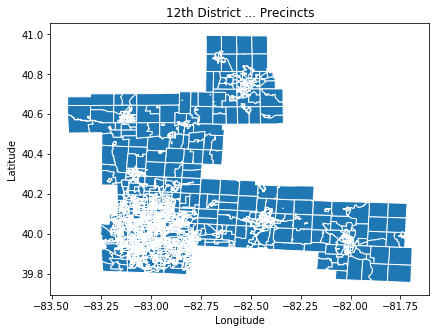

In [104]:
# plot Delaware county precincts
fig = twelfth_df.plot(figsize=[7,5], edgecolor='white')

fig.set_title('12th District ... Precincts')
fig.set_xlabel('Longitude')
fig.set_ylabel('Latitude')

# # save to file
# plt.savefig('Delaware.png')

plt.show()

This looks good. So, this approach will now be applied to the whole dataframe. But first, a bit of data cleaning must be done.

In [7]:
# indices of columns containing raw vote counts
i_start = precincts_gdf.columns.get_loc("pres_16_james_jerome_bell_wi")
i_end = precincts_gdf.columns.get_loc("pres_16_donald_j_trump_r")

# drop any row that has a null/NaN/inf value in ANY of the vote count columns
for i in range(i_start,i_end+1):
    precincts_gdf = precincts_gdf[~pd.isnull(precincts_gdf.iloc[:,i])].copy()
    
# reset row index values to for easy looping AND to add new columns (index values must match)
precincts_gdf.reset_index(inplace=True)

# remove COLUMN named 'index'
precincts_gdf.drop('index', axis=1, inplace=True)

# only keep rows with non-empty geometry cells (make copy to avoid slice overwriting)
ohio_df = precincts_gdf[~precincts_gdf["geometry"].is_empty].copy()

In [8]:
# check
print(ohio_df.shape)
ohio_df.head()

(10295, 38)


,PRECINCT,COUNTY,global_id,COUNTYGEOID10,PRECINCT_election_results,PRECINCTCODE_election_results,PRECINCT_misfit,county_name,precinct_code,region_name,media_market,pres_16_registered_voters,pres_16_total_voters,pres_16_turnout_percentage,pres_16_james_jerome_bell_wi,pres_16_michael_bickelmeyer_wi,pres_16_darrell_l_castle_wi,pres_16_hillary_clinton_d,pres_16_richard_duncan,pres_16_cherunda_fox_wi,pres_16_ben_hartnell_wi,pres_16_tom_hoefling_wi,pres_16_bruce_e_jaynes_wi,pres_16_gary_johnson,pres_16_chris_keniston_wi,pres_16_barry_kirschner_wi,pres_16_laurence_kotlikoff_wi,pres_16_joseph_maldonado_wi,pres_16_michael_andrew_maturen_wi,pres_16_evan_mc_mullin_wi,pres_16_monica_moorehead_wi,pres_16_joe_schriner_wi,pres_16_mike_smith_wi,pres_16_jill_stein_g,pres_16_josiah_r_stroh_wi,pres_16_douglas_w_thomson_wi,pres_16_donald_j_trump_r,geometry
0,GALLIPOLIS CITY 1,gallia,4179.0,39053.0,GALLIPOLIS CITY 1,AAA,None,Gallia,AAA,Southeast,Charleston,601.0,386.0,64.23,0.0,0.0,0.0,100.0,2.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,267.0,(POLYGON ((-82.21852200042079 38.813...
1,GALLIPOLIS CITY 3,gallia,4180.0,39053.0,GALLIPOLIS CITY 3,AAB,None,Gallia,AAB,Southeast,Charleston,1113.0,675.0,60.65,0.0,0.0,0.0,177.0,5.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,449.0,(POLYGON ((-82.15477500020693 38.837...
2,GALLIPOLIS CITY 2,gallia,4181.0,39053.0,GALLIPOLIS CITY 2,AAE,None,Gallia,AAE,Southeast,Charleston,582.0,393.0,67.53,0.0,0.0,0.0,113.0,3.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,247.0,(POLYGON ((-82.20163199954212 38.820...
3,ADDISON TOWNSHIP,gallia,4182.0,39053.0,ADDISON TWP,AAG,None,Gallia,AAG,Southeast,Charleston,1357.0,984.0,72.51,0.0,0.0,0.0,167.0,12.0,0.0,0.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,752.0,(POLYGON ((-82.16222800051644 38.932...
4,CHESHIRE TOWNSHIP,gallia,4183.0,39053.0,CHESHIRE TWP,AAI,None,Gallia,AAI,Southeast,Charleston,616.0,429.0,69.64,0.0,0.0,0.0,81.0,4.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,330.0,(POLYGON ((-82.21732899953564 38.934...


Calculate the centroids for all precincts and add to dataframe.

In [9]:
# allocate empty lists for latitude and longitude
oh_lon = []
oh_lat = []

# loop over all precincts Napoleon & calculate lat/lon using GeoPandas built-in method
for i in range(0,ohio_df.shape[0]):
    lon = ohio_df.iloc[i]["geometry"].centroid.coords[0][0]
    lat = ohio_df.iloc[i]["geometry"].centroid.coords[0][1]
    oh_lon.append(lon)
    oh_lat.append(lat)
    
# convert lists to dataframes
oh_lon_df = pd.DataFrame(oh_lon)
oh_lat_df = pd.DataFrame(oh_lat)

# add lon/lat columns to original Napoleon_df dataframe to plot
ohio_df["centroid_lon"] = oh_lon_df
ohio_df["centroid_lat"] = oh_lat_df

In [10]:
# check
print(ohio_df.shape)
ohio_df.head()

(10295, 40)


,PRECINCT,COUNTY,global_id,COUNTYGEOID10,PRECINCT_election_results,PRECINCTCODE_election_results,PRECINCT_misfit,county_name,precinct_code,region_name,media_market,pres_16_registered_voters,pres_16_total_voters,pres_16_turnout_percentage,pres_16_james_jerome_bell_wi,pres_16_michael_bickelmeyer_wi,pres_16_darrell_l_castle_wi,pres_16_hillary_clinton_d,pres_16_richard_duncan,pres_16_cherunda_fox_wi,pres_16_ben_hartnell_wi,pres_16_tom_hoefling_wi,pres_16_bruce_e_jaynes_wi,pres_16_gary_johnson,pres_16_chris_keniston_wi,pres_16_barry_kirschner_wi,pres_16_laurence_kotlikoff_wi,pres_16_joseph_maldonado_wi,pres_16_michael_andrew_maturen_wi,pres_16_evan_mc_mullin_wi,pres_16_monica_moorehead_wi,pres_16_joe_schriner_wi,pres_16_mike_smith_wi,pres_16_jill_stein_g,pres_16_josiah_r_stroh_wi,pres_16_douglas_w_thomson_wi,pres_16_donald_j_trump_r,geometry,centroid_lon,centroid_lat
0,GALLIPOLIS CITY 1,gallia,4179.0,39053.0,GALLIPOLIS CITY 1,AAA,None,Gallia,AAA,Southeast,Charleston,601.0,386.0,64.23,0.0,0.0,0.0,100.0,2.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,267.0,(POLYGON ((-82.21852200042079 38.813...,-82.213177,38.806066
1,GALLIPOLIS CITY 3,gallia,4180.0,39053.0,GALLIPOLIS CITY 3,AAB,None,Gallia,AAB,Southeast,Charleston,1113.0,675.0,60.65,0.0,0.0,0.0,177.0,5.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,449.0,(POLYGON ((-82.15477500020693 38.837...,-82.177677,38.824904
2,GALLIPOLIS CITY 2,gallia,4181.0,39053.0,GALLIPOLIS CITY 2,AAE,None,Gallia,AAE,Southeast,Charleston,582.0,393.0,67.53,0.0,0.0,0.0,113.0,3.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,247.0,(POLYGON ((-82.20163199954212 38.820...,-82.211522,38.816566
3,ADDISON TOWNSHIP,gallia,4182.0,39053.0,ADDISON TWP,AAG,None,Gallia,AAG,Southeast,Charleston,1357.0,984.0,72.51,0.0,0.0,0.0,167.0,12.0,0.0,0.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,752.0,(POLYGON ((-82.16222800051644 38.932...,-82.178235,38.890661
4,CHESHIRE TOWNSHIP,gallia,4183.0,39053.0,CHESHIRE TWP,AAI,None,Gallia,AAI,Southeast,Charleston,616.0,429.0,69.64,0.0,0.0,0.0,81.0,4.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,330.0,(POLYGON ((-82.21732899953564 38.934...,-82.157784,38.969485


Ok, this is all that is needed for the next section. However, a little bit more work can be done here by creating a binary "winner" column (0=Trump, 1=Clinton) and plotting all precincts colored by "winner" (red=Trump, blue=Clinton).

In [11]:
# list of columns that contain vote counts
vote_columns = ['pres_16_james_jerome_bell_wi',
       'pres_16_michael_bickelmeyer_wi', 'pres_16_darrell_l_castle_wi',
       'pres_16_hillary_clinton_d', 'pres_16_richard_duncan',
       'pres_16_cherunda_fox_wi', 'pres_16_ben_hartnell_wi',
       'pres_16_tom_hoefling_wi', 'pres_16_bruce_e_jaynes_wi',
       'pres_16_gary_johnson', 'pres_16_chris_keniston_wi',
       'pres_16_barry_kirschner_wi', 'pres_16_laurence_kotlikoff_wi',
       'pres_16_joseph_maldonado_wi', 'pres_16_michael_andrew_maturen_wi',
       'pres_16_evan_mc_mullin_wi', 'pres_16_monica_moorehead_wi',
       'pres_16_joe_schriner_wi', 'pres_16_mike_smith_wi',
       'pres_16_jill_stein_g', 'pres_16_josiah_r_stroh_wi',
       'pres_16_douglas_w_thomson_wi', 'pres_16_donald_j_trump_r']

# create column with lead vote winner name
ohio_df["winner"] = ohio_df[vote_columns].astype(int).idxmax(axis='columns')

# create empty list containing for winner as binary: 0/1 == Trump/Hillary
win_bi = []

# assign binary values...
for i in range(0,ohio_df.shape[0]):
    if (ohio_df.iloc[i]["winner"] == "pres_16_donald_j_trump_r"):
        win_bi.append(0)
    elif (ohio_df.iloc[i]["winner"] == "pres_16_hillary_clinton_d"):
        win_bi.append(1)
    else:
        print("else @ i=",i)
        
ohio_df["winner_binary"] = win_bi

In [12]:
# add column 'Precinct_ID' == index (need for merging w/ yet-to-exist venue dataframe)
ohio_df["Precinct_ID"] = ohio_df.index

# move "Precinct_ID" to first column
ohio_df = ohio_df.set_index('Precinct_ID').reset_index()

In [13]:
# check final dataframe (last 5 columns are relevant for plotting)
print(ohio_df.shape)
ohio_df.head()

(10295, 43)


,Precinct_ID,PRECINCT,COUNTY,global_id,COUNTYGEOID10,PRECINCT_election_results,PRECINCTCODE_election_results,PRECINCT_misfit,county_name,precinct_code,region_name,media_market,pres_16_registered_voters,pres_16_total_voters,pres_16_turnout_percentage,pres_16_james_jerome_bell_wi,pres_16_michael_bickelmeyer_wi,pres_16_darrell_l_castle_wi,pres_16_hillary_clinton_d,pres_16_richard_duncan,pres_16_cherunda_fox_wi,pres_16_ben_hartnell_wi,pres_16_tom_hoefling_wi,pres_16_bruce_e_jaynes_wi,pres_16_gary_johnson,pres_16_chris_keniston_wi,pres_16_barry_kirschner_wi,pres_16_laurence_kotlikoff_wi,pres_16_joseph_maldonado_wi,pres_16_michael_andrew_maturen_wi,pres_16_evan_mc_mullin_wi,pres_16_monica_moorehead_wi,pres_16_joe_schriner_wi,pres_16_mike_smith_wi,pres_16_jill_stein_g,pres_16_josiah_r_stroh_wi,pres_16_douglas_w_thomson_wi,pres_16_donald_j_trump_r,geometry,centroid_lon,centroid_lat,winner,winner_binary
0,0,GALLIPOLIS CITY 1,gallia,4179.0,39053.0,GALLIPOLIS CITY 1,AAA,None,Gallia,AAA,Southeast,Charleston,601.0,386.0,64.23,0.0,0.0,0.0,100.0,2.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,267.0,(POLYGON ((-82.21852200042079 38.813...,-82.213177,38.806066,pres_16_donald_j_trump_r,0
1,1,GALLIPOLIS CITY 3,gallia,4180.0,39053.0,GALLIPOLIS CITY 3,AAB,None,Gallia,AAB,Southeast,Charleston,1113.0,675.0,60.65,0.0,0.0,0.0,177.0,5.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,449.0,(POLYGON ((-82.15477500020693 38.837...,-82.177677,38.824904,pres_16_donald_j_trump_r,0
2,2,GALLIPOLIS CITY 2,gallia,4181.0,39053.0,GALLIPOLIS CITY 2,AAE,None,Gallia,AAE,Southeast,Charleston,582.0,393.0,67.53,0.0,0.0,0.0,113.0,3.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,247.0,(POLYGON ((-82.20163199954212 38.820...,-82.211522,38.816566,pres_16_donald_j_trump_r,0
3,3,ADDISON TOWNSHIP,gallia,4182.0,39053.0,ADDISON TWP,AAG,None,Gallia,AAG,Southeast,Charleston,1357.0,984.0,72.51,0.0,0.0,0.0,167.0,12.0,0.0,0.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,752.0,(POLYGON ((-82.16222800051644 38.932...,-82.178235,38.890661,pres_16_donald_j_trump_r,0
4,4,CHESHIRE TOWNSHIP,gallia,4183.0,39053.0,CHESHIRE TWP,AAI,None,Gallia,AAI,Southeast,Charleston,616.0,429.0,69.64,0.0,0.0,0.0,81.0,4.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,330.0,(POLYGON ((-82.21732899953564 38.934...,-82.157784,38.969485,pres_16_donald_j_trump_r,0


In [14]:
# convert back to original CRS for improved plotting
ohio_df = ohio_df.to_crs(epsg=2958)

In [15]:
# import library to create custom colormap
from matplotlib.colors import LinearSegmentedColormap

In [16]:
# create custom colormap (red=Trump, blue=Clinton)
cmap2 = LinearSegmentedColormap.from_list("", ["xkcd:crimson","xkcd:indigo"])

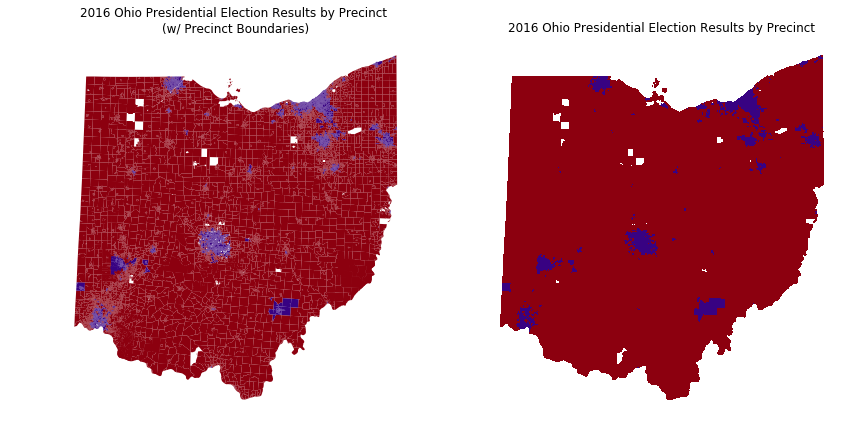

In [17]:
# plot actual election results (left=precinct borders, right=no borders)
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=[14,7])
ohio_df.plot(ax=ax1, column='winner_binary', cmap=cmap2)
ohio_df.plot(ax=ax2, column='winner_binary', cmap=cmap2, antialiased=False)
ax1.axis('off')
ax2.axis('off')
ax1.set_title('2016 Ohio Presidential Election Results by Precinct \n(w/ Precinct Boundaries)')
ax2.set_title('2016 Ohio Presidential Election Results by Precinct')
plt.savefig('2_ohio_map.png')
plt.show()

These maps represent the 2016 Presidential election results in Ohio at the precinct level. On the left, the precinct boundaries are denoted by white semitransparent lines, and in areas of high precinct density (cities), these lines can appear to create a specious third color in the form of a lighter blue. Therefore, the exact same map is plotted on the right, but the boundaries are ommited. Obviously, there a few precincts missing (the white gaps in the map). Nonetheless, this gives a good overview: the cities tend to vote Democratic (blue) and the rest of the state tends to vote Republican (red).

#### Data: Characterizing precincts by their venues/businesses/services (Foursquare data)

The third data set that is needed must somehow characterize the precincts in a way that lends itself to the rural/urban labeling. To do this, Foursquare (www.foursquare.com) venue data is utilized to generate feature sets for each precinct. The feature sets will be comprised of the venue category types (i.e. "Italian Restaurant", "Gas Station", "Auto Mechanic", etc.) for the venues found in each precinct. Calls to the Foursquare API return JSON information, which will be transformed into a Pandas dataframe for analysis. Although precincts won't iniitally be labeled as as rural or urban, once we have done some analysis, we will see if there are any precinct voting patterns that support the rural/urban stereotypes. 

In [18]:
# import libraries
import json # JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

In [19]:
# Foursqaure credentials and version info

CLIENT_ID = 'XXX' # your Foursquare ID
CLIENT_SECRET = 'XXX' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Credentails:
CLIENT_ID: XXX
CLIENT_SECRET:XXX


In [20]:
# Create a function to "explore" (get venues for) all the precincts
def getNearbyVenues(names, latitudes, longitudes, radius=3500, LIMIT = 100):
    
    # allocate empty venues list
    venues_list=[]
    
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
#         try:
#             results = requests.get(url).json()["response"]['groups'][0]['items']
#         except:
#             print(name)
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Precinct_ID', 
                  'Precinct Latitude', 
                  'Precinct Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

It should be noted that "The Foursquare API has a limit of 950 Regular API Calls per day". However, by verifying a Foursquare account with a credit card (which is not charged), this limit is raised to 99,500 calls per day. The following commented code cell shows the code to request the Foursquare data, but is not used here. Instead, this code was previously run (since getting this information from the Foursquare API can be time consuming), and the Foursquare data was saved to CSV file.

In [21]:
# # call the function
# precinct_venues = getNearbyVenues(names=pd.Series(ohio_df.index.values),
#                                  latitudes=ohio_df['centroid_lat'],
#                                  longitudes=ohio_df['centroid_lon']
#                                  )

Load the Foursquare venue data that I had previously saved to a CSV file:

In [22]:
# load the cached Foursqaure data (rather make calls to FQ API again)
precinct_venues = pd.read_csv("precinct_venues_agg_FQ.csv")

In [23]:
# drop 'Unnamed: 0' column
precinct_venues.drop(['Unnamed: 0'], axis=1, inplace=True)

# rename column to match column in ohio_df
precinct_venues.rename(columns={"Precinct": "Precinct_ID"}, inplace=True)

In [24]:
# check it out
print(precinct_venues.shape)
print(precinct_venues.columns)
precinct_venues.head()

(528644, 7)
Index(['Precinct_ID', 'Precinct Latitude', 'Precinct Longitude', 'Venue',
       'Venue Latitude', 'Venue Longitude', 'Venue Category'],
      dtype='object')


,Precinct_ID,Precinct Latitude,Precinct Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,0,38.806066,-82.213177,Courtside Bar And Grill,38.806786,-82.206826,Bar
1,0,38.806066,-82.213177,Shake Shoppe,38.814543,-82.194659,Fast Food Restaurant
2,0,38.806066,-82.213177,Dollar General,38.807222,-82.206783,Discount Store
3,0,38.806066,-82.213177,Speedway,38.813934,-82.197190,Gas Station
4,0,38.806066,-82.213177,Tuscany Cuccini,38.817761,-82.185092,Italian Restaurant


Each row contains venue location and category data. Each venue is mapped to the corresponding precinct. Some precincts may have multiple venues, so are shown in multiple rows. Some precincts may not have any venues, so are not present in this dataframe (this will be accounted for in a following section).

#### Data: Convert venue categories to *one-hot* feature set

This venue data must now be converted into a format that lends itself to clustering/classification algorithms. First, a dataframe is created which contains every venue found in Ohio, where each venue is represented as a single row. Second, a column is assigned to every possible venue category, where each venue row assigns a value of 1 to the column of the corresponding venue category, and assigns a value of 0 to all other columns. Third, all venues in each precinct are combined into a single row and the venue category columns are summed to produce raw counts of every venue category in each precinct. Finally, the summed venue category columns are normalized for each precint, so that all precincts will have the same weight when building a model.

In [25]:
# import library
import numpy as np

In [26]:
# one hot encoding dataframe
precinct_onehot = pd.get_dummies(precinct_venues[['Venue Category']], prefix="", prefix_sep="")

# replace column 'Neighborhood' ==> 'Precinct' (remnant of old code...)
precinct_onehot.rename(columns={"Neighborhood": "Precinct_ID"}, inplace=True)

# convert current Precinct_ID column from one-hot to the actual precinct ID# 
precinct_onehot['Precinct_ID'] = precinct_venues['Precinct_ID']

# move Precinct_ID column to the first column
precinct_onehot = precinct_onehot.set_index('Precinct_ID').reset_index()

# combine each unique precinct into a single row ==> take average of one-hot values
precinct_grouped = precinct_onehot.groupby('Precinct_ID').mean().reset_index()

# check
print(precinct_grouped.shape)
precinct_grouped.head()

(10142, 528)


,Precinct_ID,ATM,Accessories Store,Adult Boutique,Advertising Agency,African Restaurant,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Apres Ski Bar,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Assisted Living,Astrologer,Athletics & Sports,Australian Restaurant,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Bavarian Restaurant,Bay,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat Rental,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Bulgarian Restaurant,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Canal Lock,Candy Store,Cantonese Restaurant,Capitol Building,Car Wash,Caribbean Restaurant,Carpet Store,Casino,Castle,Cave,Cemetery,Cheese Shop,Child Care Service,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Circus,City,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Auditorium,College Baseball Diamond,College Basketball Court,College Bookstore,College Cafeteria,College Football Field,College Gym,College Hockey Rink,College Quad,College Rec Center,College Science Building,College Theater,College Track,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Costume Shop,Coworking Space,Credit Union,Cuban Restaurant,Cultural Center,Cupcake Shop,Curling Ice,Cycle Studio,Czech Restaurant,Dance Studio,Deli / Bodega,Dentist's Office,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Disc Golf,Discount Store,Distillery,Dive Bar,Dive Spot,Doctor's Office,Dog Run,Donut Shop,Drive-in Theater,Drugstore,Dry Cleaner,Dutch Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Empanada Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Fabric Shop,Factory,Fair,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Festival,Field,Filipino Restaurant,Financial or Legal Service,Fire Station,Fireworks Store,Fish & Chips Shop,Fish Market,Fishing Spot,Fishing Store,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Football Stadium,Forest,Fountain,Frame Store,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gun Range,Gun Shop,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,High School,Hill,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Field,Hockey Rink,Home Service,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,Housing Development,Hunan Restaurant,Hungarian Restaurant,Hunting Supply,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Insurance Office,Internet Cafe,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen S

#### Data: Merge precinct voting dataframe & Foursquare one-hot venue dataframe

The dataframe containing the precinct vote counts and boundaries is combined with the one-hot venue dataframe. Since the precinct vote dataframe contains all Precinct_ID's, but the one-hot dataframe does not, those Precinct_ID's not present are assigned 'NaN' in the one-hot section of the newly merged dataframe. Therefore, these 'NaN' values are replaced with zeros, which makes sense since these are precincts without any venues.

In [27]:
# merge based on the common column 'Precinct_ID' found in both dataframes
df_merged = ohio_df.merge(precinct_grouped, how='outer', on='Precinct_ID')

# find column indices for one-hot section of new df
j_start = df_merged.columns.get_loc("ATM")
j_end = df_merged.columns.get_loc("Zoo Exhibit")

# assign value of zero to all NaN values in one-hot section of df_merged
df_merged.fillna(0, inplace=True)

# check
print(df_merged.shape)
df_merged.head()

(10295, 570)


,Precinct_ID,PRECINCT,COUNTY,global_id,COUNTYGEOID10,PRECINCT_election_results,PRECINCTCODE_election_results,PRECINCT_misfit,county_name,precinct_code,region_name,media_market,pres_16_registered_voters,pres_16_total_voters,pres_16_turnout_percentage,pres_16_james_jerome_bell_wi,pres_16_michael_bickelmeyer_wi,pres_16_darrell_l_castle_wi,pres_16_hillary_clinton_d,pres_16_richard_duncan,pres_16_cherunda_fox_wi,pres_16_ben_hartnell_wi,pres_16_tom_hoefling_wi,pres_16_bruce_e_jaynes_wi,pres_16_gary_johnson,pres_16_chris_keniston_wi,pres_16_barry_kirschner_wi,pres_16_laurence_kotlikoff_wi,pres_16_joseph_maldonado_wi,pres_16_michael_andrew_maturen_wi,pres_16_evan_mc_mullin_wi,pres_16_monica_moorehead_wi,pres_16_joe_schriner_wi,pres_16_mike_smith_wi,pres_16_jill_stein_g,pres_16_josiah_r_stroh_wi,pres_16_douglas_w_thomson_wi,pres_16_donald_j_trump_r,geometry,centroid_lon,centroid_lat,winner,winner_binary,ATM,Accessories Store,Adult Boutique,Advertising Agency,African Restaurant,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Apres Ski Bar,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Assisted Living,Astrologer,Athletics & Sports,Australian Restaurant,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Bavarian Restaurant,Bay,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat Rental,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Bulgarian Restaurant,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Canal Lock,Candy Store,Cantonese Restaurant,Capitol Building,Car Wash,Caribbean Restaurant,Carpet Store,Casino,Castle,Cave,Cemetery,Cheese Shop,Child Care Service,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Circus,City,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Auditorium,College Baseball Diamond,College Basketball Court,College Bookstore,College Cafeteria,College Football Field,College Gym,College Hockey Rink,College Quad,College Rec Center,College Science Building,College Theater,College Track,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Costume Shop,Coworking Space,Credit Union,Cuban Restaurant,Cultural Center,Cupcake Shop,Curling Ice,Cycle Studio,Czech Restaurant,Dance Studio,Deli / Bodega,Dentist's Office,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Disc Golf,Discount Store,Distillery,Dive Bar,Dive Spot,Doctor's Office,Dog Run,Donut Shop,Drive-in Theater,Drugstore,Dry Cleaner,Dutch Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Empanada Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Fabric Shop,Factory,Fair,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Festival,Field,Filipino Restaurant,Financial or Legal Service,Fire Station,Fireworks Store,Fish & Chips Shop,Fish Market,Fishing Spot,Fishing Store,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Football Stadium,Forest,Fountain,Frame Store,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant

## Methodology & Results

In this section, the data will be explored via combination of clustering and classification algortihms. First, a clustering algorithm will be employed to see if the venue data alone is sufficient to cluster the precincts in accordance with the 2016 Presidential election results. It will be shown that the venue data alone is not sufficient, but including the results themselves does allow for some sub-class (within Republican and Democratic precincts) delineation. 

Then, a handful of classification algorithms are tested on the venue data alone to generate an optimal model for predicting how an Ohio precinct voted. The results allow for some exploration of the characteristics of Democratic and Republican precincts. 

#### Methodology & Results: Clustering with K-Means (k=2)

A thorough explanation of the k-means clustering method is beyond the scope of this work. But, the sci-kit learn online User Guide (https://scikit-learn.org/stable/modules/clustering.html#k-means), and, of course, WikiPedia (https://en.wikipedia.org/wiki/K-means_clustering), are good places to start.

In [28]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

In [29]:
# find column indices for one-hot section of new df
j_start = df_merged.columns.get_loc("ATM")
j_end = df_merged.columns.get_loc("Zoo Exhibit")

# isolate one-hot section
print(df_merged.iloc[:,j_start:j_end+1].shape)
df_merged.iloc[0:5,j_start:j_end+1]

(10295, 527)


,ATM,Accessories Store,Adult Boutique,Advertising Agency,African Restaurant,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Apres Ski Bar,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Assisted Living,Astrologer,Athletics & Sports,Australian Restaurant,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Bavarian Restaurant,Bay,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat Rental,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Bulgarian Restaurant,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Canal Lock,Candy Store,Cantonese Restaurant,Capitol Building,Car Wash,Caribbean Restaurant,Carpet Store,Casino,Castle,Cave,Cemetery,Cheese Shop,Child Care Service,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Circus,City,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Auditorium,College Baseball Diamond,College Basketball Court,College Bookstore,College Cafeteria,College Football Field,College Gym,College Hockey Rink,College Quad,College Rec Center,College Science Building,College Theater,College Track,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Costume Shop,Coworking Space,Credit Union,Cuban Restaurant,Cultural Center,Cupcake Shop,Curling Ice,Cycle Studio,Czech Restaurant,Dance Studio,Deli / Bodega,Dentist's Office,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Disc Golf,Discount Store,Distillery,Dive Bar,Dive Spot,Doctor's Office,Dog Run,Donut Shop,Drive-in Theater,Drugstore,Dry Cleaner,Dutch Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Empanada Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Fabric Shop,Factory,Fair,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Festival,Field,Filipino Restaurant,Financial or Legal Service,Fire Station,Fireworks Store,Fish & Chips Shop,Fish Market,Fishing Spot,Fishing Store,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Football Stadium,Forest,Fountain,Frame Store,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gun Range,Gun Shop,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,High School,Hill,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Field,Hockey Rink,Home Service,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,Housing Development,Hunan Restaurant,Hungarian Restaurant,Hunting Supply,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Insurance Office,Internet Cafe,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,

In [30]:
# set number of clusters, try k=2 first, since vote can be Rep or Dem only
kclusters = 2

# isolate one-hot section of df_merged
oh_clust = df_merged.iloc[:,j_start:j_end+1]

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(oh_clust)

In [31]:
# overwrite column for cluster labels
if 'cluster' in df_merged.columns:
    df_merged['cluster'] = kmeans.labels_
# add column for cluster labels
else:
    df_merged.insert(0, 'cluster', kmeans.labels_)

In [32]:
# check cluster categories
df_merged["cluster"].unique()

array([0, 1])

In [33]:
# check counts of each cluster
df_merged["cluster"].value_counts()

0    9921
1     374
Name: cluster, dtype: int64

In [34]:
# compare to actual precinct counts (0=Trump, 1=Clinton)
df_merged["winner_binary"].value_counts()

0    7163
1    3132
Name: winner_binary, dtype: int64

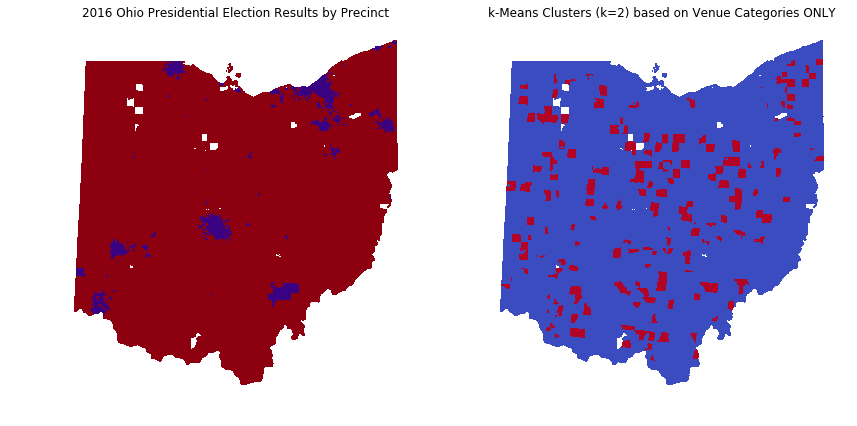

In [35]:
# plot actual election results vs. clusters
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=[14,7])
df_merged.plot(ax=ax1, column='winner_binary', antialiased=False, cmap=cmap2)
df_merged.plot(ax=ax2, column='cluster', antialiased=False, cmap='coolwarm')
ax1.axis('off')
ax2.axis('off')
ax1.set_title('2016 Ohio Presidential Election Results by Precinct')
ax2.set_title('k-Means Clusters (k=2) based on Venue Categories ONLY')
plt.savefig('3_clusters2_map.png')
plt.show()

Clearly, two clusters are not sufficient to describe the precincts. Therefore, *at least* three clusters are needed. It appears that the cluster represented by small squares are far from major cities, so perhaps these are very rural. The k-means clustering algorithm will be applied for k=(3,5,10) to see if there is anything to be learned about the precincts from their venues.

#### Methodology & Results: Clustering with K-Means (k=3,5,10)

In [36]:
def kMeansPlot(k, plotclusters=True, cmapchoice='coolwarm'):
    """
    1. Apply the k-means clustering algorithm to the df_merged dataframe.
    2. Plot the resulting color-coded precincts clusters as an Ohio map.
    """

    # find column indices for one-hot section of new df
    j_start = df_merged.columns.get_loc("ATM")
    j_end = df_merged.columns.get_loc("Zoo Exhibit")

    # set number of clusters
    kclusters = k

    # isolate one-hot section of df_merged
    oh_clust = df_merged.iloc[:,j_start:j_end+1]

    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(oh_clust)

    # overwrite column for cluster labels
    if 'cluster' in df_merged.columns:
        df_merged['cluster'] = kmeans.labels_
    # add column for cluster labels
    else:
        df_merged.insert(0, 'cluster', kmeans.labels_)

    if (plotclusters==True):
        # plot clusters
        fig = df_merged.plot(column='cluster', 
                       figsize=[5,5], 
                       antialiased=False, 
                       cmap=cmapchoice)
        fig.set_title('Ohio Precinct Clusters (k={})'.format(k))
        plt.axis('off')
        plt.savefig('X_clustersX_map.png', bbox_inches='tight')

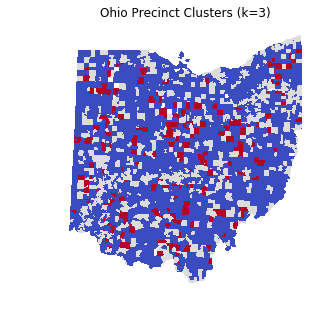

In [37]:
# plot the results of k-means clustering w/ k=3
kMeansPlot(3)

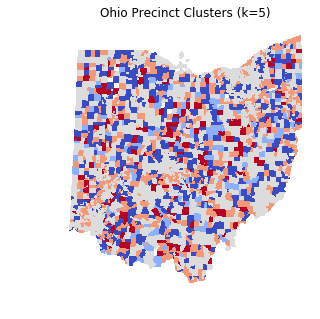

In [38]:
# plot the results of k-means clustering w/ k=5
kMeansPlot(5)

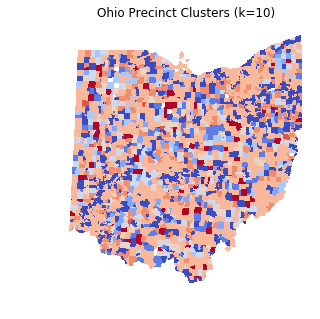

In [39]:
# plot the results of k-means clustering w/ k=10
kMeansPlot(10)

Unfortunately, with the venue category feature set alone, the k-means clustering algorithm does not provide clear precinct separation in a way that reflects the results of the 2016 Presidential Election.

#### Methodology & Results: Data exploration using k-means clustering (k=3)

If the results of the election are included in the feature set, along with the venue categories, the k-means clustering algorithm can provide some further understanding of the precincts beyond merely separating the precincts by election results alone. This new one-hot matrix data will be separated into a dataframe for each cluster so that they can be characterized. So, rather than use the method we used above, it must be modified so that the selected one-hot columns also include the 'winner_binary' column.

In [40]:
# find column indices for one-hot section of new df
j_start = df_merged.columns.get_loc("ATM")
j_end = df_merged.columns.get_loc("Zoo Exhibit")

# check
df_merged.iloc[:,j_start-1:j_end+1].head()

,winner_binary,ATM,Accessories Store,Adult Boutique,Advertising Agency,African Restaurant,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Apres Ski Bar,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Assisted Living,Astrologer,Athletics & Sports,Australian Restaurant,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Bavarian Restaurant,Bay,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat Rental,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Bulgarian Restaurant,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Canal Lock,Candy Store,Cantonese Restaurant,Capitol Building,Car Wash,Caribbean Restaurant,Carpet Store,Casino,Castle,Cave,Cemetery,Cheese Shop,Child Care Service,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Circus,City,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Auditorium,College Baseball Diamond,College Basketball Court,College Bookstore,College Cafeteria,College Football Field,College Gym,College Hockey Rink,College Quad,College Rec Center,College Science Building,College Theater,College Track,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Costume Shop,Coworking Space,Credit Union,Cuban Restaurant,Cultural Center,Cupcake Shop,Curling Ice,Cycle Studio,Czech Restaurant,Dance Studio,Deli / Bodega,Dentist's Office,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Disc Golf,Discount Store,Distillery,Dive Bar,Dive Spot,Doctor's Office,Dog Run,Donut Shop,Drive-in Theater,Drugstore,Dry Cleaner,Dutch Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Empanada Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Fabric Shop,Factory,Fair,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Festival,Field,Filipino Restaurant,Financial or Legal Service,Fire Station,Fireworks Store,Fish & Chips Shop,Fish Market,Fishing Spot,Fishing Store,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Football Stadium,Forest,Fountain,Frame Store,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gun Range,Gun Shop,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,High School,Hill,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Field,Hockey Rink,Home Service,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,Housing Development,Hunan Restaurant,Hungarian Restaurant,Hunting Supply,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Insurance Office,Internet Cafe,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen

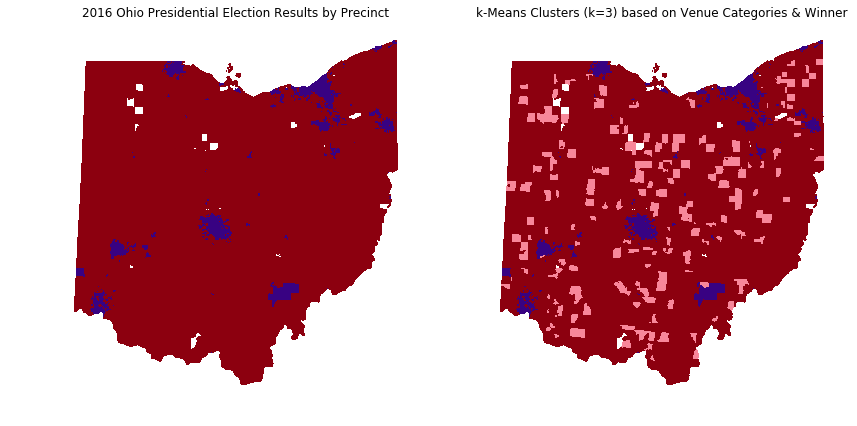

In [41]:
# set number of clusters
kclusters = 3

# isolate one-hot section of df_merged (INCLUDE 'winner_binary' column)
oh_clust = df_merged.iloc[:,j_start-1:j_end+1]

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(oh_clust)

# overwrite column for cluster labels
if 'cluster' in df_merged.columns:
    df_merged['cluster'] = kmeans.labels_
# add column for cluster labels
else:
    df_merged.insert(0, 'cluster', kmeans.labels_)
    
# custom colormap
cmap3 = LinearSegmentedColormap.from_list("", ["xkcd:rose pink","xkcd:indigo","xkcd:crimson"])

# plot actual election results vs. clusters
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=[14,7])
df_merged.plot(ax=ax1, column='winner_binary', antialiased=False, cmap=cmap2)
df_merged.plot(ax=ax2, column='cluster', antialiased=False, cmap=cmap3)
ax1.axis('off')
ax2.axis('off')
ax1.set_title('2016 Ohio Presidential Election Results by Precinct')
ax2.set_title('k-Means Clusters (k=3) based on Venue Categories & Winner')
plt.savefig('7_clust3_win_map.png')
plt.show()

The k-means clustering algorithm has isolated the Democratic precincts into a single cluster, and split the Republican precincts into two clusters. Of course, we could get finer granularity about different types of Republican and Democratic precincts by increasing the number of clusters. However, for the purposes here, only three clusters are needed to get some insight into rural and urban voting patterns. In addition, later in this notebook, classification algorithms will be used to determine the predictive power of venue categories on precinct voting patterns.

In [42]:
df_merged['cluster'].value_counts()

2    6788
1    3132
0     375
Name: cluster, dtype: int64

In [43]:
# create df containing only 'cluster' and 'Precinct_ID'
clust_ID = df_merged[['cluster', 'Precinct_ID']]

# merge clust_ID & one-hot df 
onehot_clusters = clust_ID.merge(precinct_onehot, how='outer', on='Precinct_ID')

In [44]:
# check which clusters contain precincts w/o any venues
precID_none = onehot_clusters[onehot_clusters.isna().any(axis=1)][['cluster','Precinct_ID']]
print(precID_none.shape)
print(precID_none['cluster'].unique())

(153, 2)
[2]


All precincts w/o any venues were assigned to cluster=2. Now replace all NaN values in the one-hot matrix with zeros.

In [45]:
# assign value of zero to all NaN values in one-hot section of df_merged
onehot_clusters.fillna(0, inplace=True)

Separate the one-hot dataframes by cluster, which will then be modified to contain raw counts of venue categories. And then generate a second dataframe for each cluster that contains the frequency of occurence of all venue categories in that cluster.

In [46]:
# separate clusters into their own dataframes
onehot_clust0 = onehot_clusters[onehot_clusters['cluster']==0]
onehot_clust1 = onehot_clusters[onehot_clusters['cluster']==1]
onehot_clust2 = onehot_clusters[onehot_clusters['cluster']==2]

# sum each venue category w/in each cluster to get gross total raw counts
counts_clust0 = onehot_clust0.iloc[:,2:].sum(axis=0)
counts_clust1 = onehot_clust1.iloc[:,2:].sum(axis=0)
counts_clust2 = onehot_clust2.iloc[:,2:].sum(axis=0)

# Sort the values of the dataframes, descending from highest to lowest
counts_clust0.sort_values(ascending=False, inplace=True)
counts_clust1.sort_values(ascending=False, inplace=True)
counts_clust2.sort_values(ascending=False, inplace=True)

# get frequency by dividing raw counts by total number of venues (in each precinct)
freq_clust0 = counts_clust0.divide(counts_clust0.sum())
freq_clust1 = counts_clust1.divide(counts_clust1.sum())
freq_clust2 = counts_clust2.divide(counts_clust2.sum())

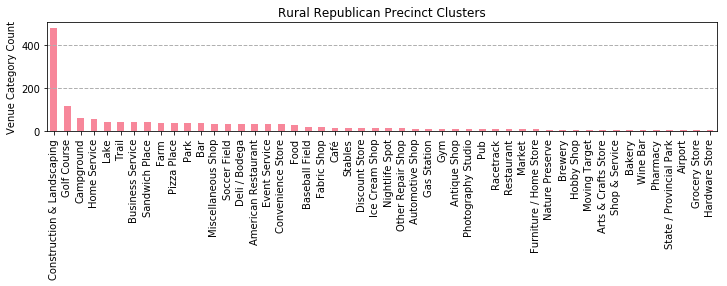

In [47]:
# plot highest occuring venue categories in each cluster
fig = counts_clust0[0:50].plot(kind='bar', 
                               figsize=[12,2],
                               color='xkcd:rose pink')

fig.set_title('Rural Republican Precinct Clusters')
fig.set_ylabel('Venue Category Count')
fig.grid(axis='y', linestyle='--', linewidth=1)
#ax = fig.set_yticks(np.arange(0,0.31,0.1))
plt.savefig('8_venuecount_Rrural.png', bbox_inches = "tight")
plt.show()

So, it's pretty clear that this cluster is highly rural, with the raw venue count dominated by 'Construction & Landscaping', and following by 'Golf Course', 'Campground', 'Lake', 'Trail', etc.

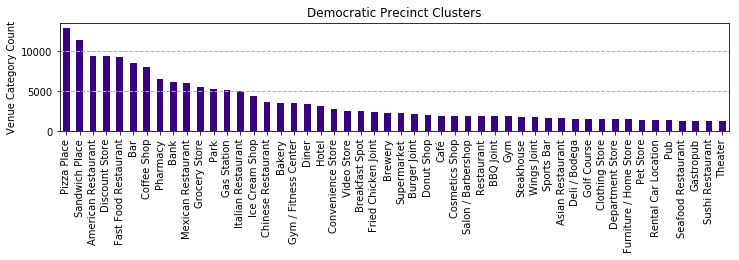

In [48]:
fig = counts_clust1[0:50].plot(kind='bar', 
                               figsize=[12,2],
                               color='xkcd:indigo')

fig.set_title('Democratic Precinct Clusters')
fig.set_ylabel('Venue Category Count')
fig.grid(axis='y', linestyle='--', linewidth=1)
#ax = fig.set_yticks(np.arange(0,0.31,0.1))
plt.savefig('9_venuecount_D.png', bbox_inches = "tight")
plt.show()

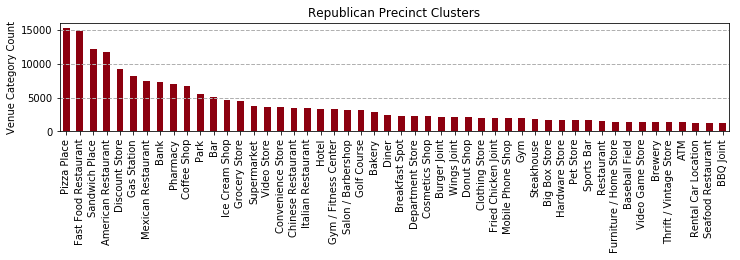

In [49]:
fig = counts_clust2[0:50].plot(kind='bar', 
                               figsize=[12,2],
                               color='xkcd:crimson')

fig.set_title('Republican Precinct Clusters')
fig.set_ylabel('Venue Category Count')
fig.grid(axis='y', linestyle='--', linewidth=1)
#ax = fig.set_yticks(np.arange(0,0.31,0.1))
plt.savefig('10_venuecount_R.png', bbox_inches = "tight")
plt.show()

The distinction between the other two clusters (all Democratic precincts vs. remaining Republican precincts) is not clear. The top five most frequently occuring venue categories are the same in both clusters, although the order is different. A more direct comparison of these two clusters is in order. It order to give the clusters equal weight, the frequency of venue category will be used in place of raw count.

In [50]:
# create dictionary of the 3 cluster frequencies
clust_dict = {'Cluster 0': freq_clust0.sort_index(), 
              'Cluster 1': freq_clust1.sort_index(), 
              'Cluster 2': freq_clust2.sort_index()
             } 

# combine into single dataframe
freq_clusters = pd.DataFrame(clust_dict) 

# create dataframes sorted by each of the two clusters
plotDem = freq_clusters.sort_values(by='Cluster 1', ascending=False)
plotRep = freq_clusters.sort_values(by='Cluster 2', ascending=False)

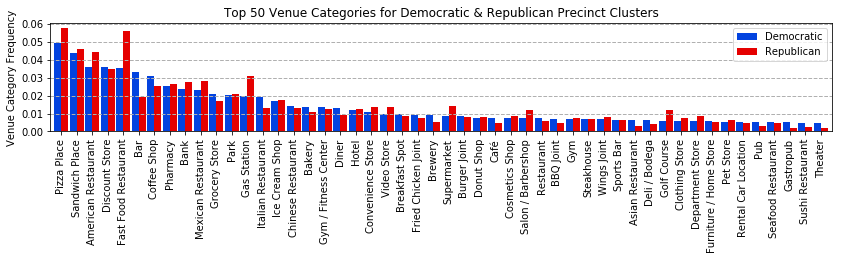

In [51]:
# plot top 50 most frequent venue categories in Democratic precints & corresponding Republican
fig = plotDem.iloc[0:50,1:].plot(kind='bar',
                                  width=0.9,
                                  figsize=[14,2],
                                  align='center',
                                  color=['xkcd:blue', 'xkcd:red']
                                    )

fig.set_title('Top 50 Venue Categories for Democratic & Republican Precinct Clusters')
fig.set_ylabel('Venue Category Frequency')
fig.legend(['Democratic', 'Republican'])
fig.grid(axis='y', linestyle='--', linewidth=1)
ax = fig.set_yticks(np.arange(0,0.061,0.01))
plt.savefig('11_freqcomp.png', bbox_inches = "tight")
plt.show()

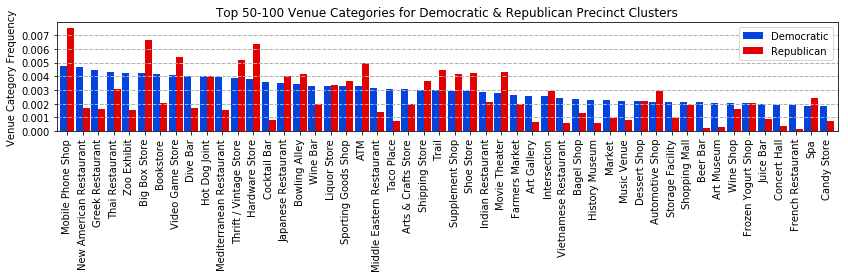

In [52]:
# plot top 50-100 most frequent venue categories in Democratic precints & corresponding Republican
fig = plotDem.iloc[50:100,1:].plot(kind='bar',
                                  width=0.9,
                                  figsize=[14,2],
                                  align='center',
                                  color=['xkcd:blue', 'xkcd:red']
                                    )

fig.set_title('Top 50-100 Venue Categories for Democratic & Republican Precinct Clusters')
fig.set_ylabel('Venue Category Frequency')
fig.legend(['Democratic', 'Republican'])
fig.grid(axis='y', linestyle='--', linewidth=1)
ax = fig.set_yticks(np.arange(0,0.008,0.001))

There are some things that stand out here. In the top 50 bar plot, a few categories stand out. 'Pizza Place', 'Fast Food Restaurant' and 'Gas Station' all occur at noticably higher frequencies in Republican precincts. Alternatively, 'Bar' stands out as the category which occurs much more frequently in Democratic precincts. As the second plot (top 50-100 categories) is examined, many categories show distinct difference in frequency of occurence. In order to highlight the categories which show the greatest discrepancy in frequency, the differences in frequency between Republican and Democratic clusters will be calculated. Then, two bar charts of these maximum differences (i. raw/gross, and ii. normalized relative to one of the two clusters) to illustrate where the two clusters diverge.

In [53]:
# calculate raw/gross differences in frequencies
freq_diff = freq_clust1.subtract(freq_clust2).abs()

# sort
freq_diff.sort_values(ascending=False, inplace=True)

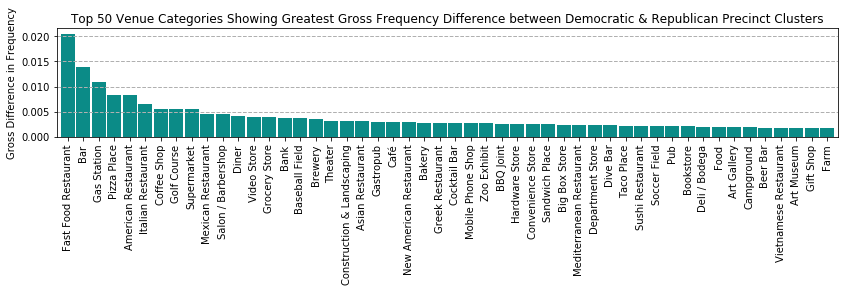

In [54]:
# plot venue categories showing greatest difference in frequency between Rep and Dem clusters
fig = freq_diff[0:50].plot(kind='bar',
                           width=0.9,
                           figsize=[14,2],
                           align='center',
                           color='xkcd:greenish blue'
                          )

fig.set_title('Top 50 Venue Categories Showing Greatest Gross Frequency Difference between Democratic & Republican Precinct Clusters')
fig.set_ylabel('Gross Difference in Frequency')
fig.grid(axis='y', linestyle='--', linewidth=1)
#ax = fig.set_yticks(np.arange(0,0.0081,0.002))
plt.savefig('12_freqdiff.png', bbox_inches = "tight")
plt.show()

This plot confirms some of what noticed from the individual figures ('Fast Food Restaurant', 'Bar'), but also highlights some less obvious categories ('Coffee Shop', 'Golf Course'). 

Next, divide the Republican frequency cluster by the Democratic frequency cluster. This will tell us *relative* difference in frequency of each venue category. Additionally, for venue categories with *relative* differences in frequency equal to zero or infinity, we know that the venue category only occurs in one of the two clusters (determined by which cluster we use as the denominator in the .divide() method below). The results will have the following characteristics:

- If the value is 'inf' then that particular venue does not exist in the Democratic cluster (divide by zero).

- If the value is 'NaN' that that particular venue does not exist in either Democratic or Republican clusters. It only exists in other Republican cluster (which is a secondary more rural Republican precinct cluster).

- At a value of 1.0, there is venue category frequency parity. 

- At a value of <1.0, the frequency of occurence of that particular venue category in the Republican cluster is a fraction of in the Democratic cluster. So it occurs more in Democratic precincts.

- At a value of >1.0, that particular venue category occurs in the Republican cluster more often than the Democratic cluster. i.e. at a value of 2.0, the venue category occurs twice as much in Republican precincts than Democratic, etc. ...

- **It's also pretty clear that the Foursquare database is not exhaustive. Probably for a variety of reasons, including that some types of venues are/are not prone to being reviewed by customers or uploaded by the owner/manager.**

In [55]:
# divide the Republican by the Democratic
freq_norm = freq_clust2.sort_index().divide(freq_clust1.sort_index())

# sort values 
freq_norm.sort_values(ascending=False, inplace=True)

In [56]:
# number of venues only occuring in Republican precincts
np.sum(np.isinf(freq_norm))

57

In [57]:
# number of venues only in Democratic precincts
freq_norm.isin([0]).sum()

20

In [58]:
# number of venues occuring in neither cluster 0 or 1
np.sum(np.isnan(freq_norm))

2

In [59]:
# venue categories only occuring in Republican precincts
freq_norm[np.isinf(freq_norm)]

Arts & Entertainment           inf
Rock Climbing Spot             inf
Stationery Store               inf
Laser Tag                      inf
Strip Club                     inf
Kebab Restaurant               inf
Surf Spot                      inf
Hunan Restaurant               inf
Housing Development            inf
Hotel Pool                     inf
Medical School                 inf
Reservoir                      inf
Canal Lock                     inf
Himalayan Restaurant           inf
Hill                           inf
Apres Ski Bar                  inf
Car Wash                       inf
Government Building            inf
Lighting Store                 inf
Modern European Restaurant     inf
Tour Provider                  inf
Perfume Shop                   inf
Real Estate Office             inf
RV Park                        inf
Professional & Other Places    inf
Platform                       inf
Bath House                     inf
Bay                            inf
Photography Lab     

In [60]:
# venue categories only occuring in Democratic precincts
freq_norm[freq_norm.isin([0])]

Tibetan Restaurant          0.0
University                  0.0
Animal Shelter              0.0
Tram Station                0.0
College Baseball Diamond    0.0
Knitting Store              0.0
Taxi Stand                  0.0
Argentinian Restaurant      0.0
Astrologer                  0.0
Czech Restaurant            0.0
Street Food Gathering       0.0
Polish Restaurant           0.0
Capitol Building            0.0
Bavarian Restaurant         0.0
Plane                       0.0
Pedestrian Plaza            0.0
Belgian Restaurant          0.0
Music School                0.0
Hungarian Restaurant        0.0
College Track               0.0
dtype: float64

The hightest values indicate venue categories that occur much more often in Republican precincts. The lowest values indicate venues that occur much more often in Democratic precincts. Looking below, 'Fishing Spot', 'Fair' and 'Rest Area' are in the top 5. These are all indicative of rural areas. Further down, but still occuring around 10x as often than in Democratic precints, we see 'Stables', 'Forest', 'Toll Booth', 'Vacation Rental', 'Campground', 'Outdoor day & Recreation', etc. Although there are some categories that don't immediately conjure images of rural countryside, like 'Australian Restaurant', 'IT Services', 'North Indian Restaurant', it seems likely that this is an artifact of the Foursquare databases not necessarily containing all venues in existance and/or that the venue categories may potentially by redundant or inaccurate. It could be that there are as many 'North Indian Restaurant' in Democratic precincts, but they are listed under a venue category of merely 'Indian Restaurant', or something along those lines.

In [61]:
# venue categories more frequently found in Republican precincts
freq_norm[~np.isinf(freq_norm)][0:20]

Fishing Spot               27.697192
Fair                       23.938287
Assisted Living            22.751265
Resort                     22.091808
Rest Area                  21.457715
Hospital                   18.794523
Australian Restaurant      17.805338
Photography Studio         17.805338
Travel Agency              15.120406
IT Services                14.727872
Paintball Field            14.508053
Stables                    11.870225
North Indian Restaurant    11.870225
Forest                     11.870225
Pet Service                11.375632
Castle                      9.891854
Vacation Rental             8.902669
Toll Booth                  8.902669
Campground                  8.489278
Outdoors & Recreation       8.078348
dtype: float64

In [62]:
# number of venues only in Democratic precincts
nzero = freq_norm.isin([0]).sum()

# number of venues occuring in neither cluster 0 or 1
nnan = np.sum(np.isnan(freq_norm))

The venue categories with the smallest normalized frequencies are those that occur much more frequently in Democratic precincts. Again, a value of 1 would mean venue category parity between Republican and Democratic precincts. So, very small values, closest to zero, would indicate venue categories than occur much more frequently in Democratic precincts. For example, 'French Restaurant' has a value of ~0.1. This means that this venue category occurs in Republican districts 10% of the time that it occurs in Democratic precincts. In other words, 'French Restaurant' occurs in Democratic precincts 1/0.1=10 times more frequently than in Republican districts.

In [63]:
# venue categories more frequently found in Democratic precincts
freq_norm[-20-nzero-nnan:-nzero-nnan]

College Basketball Court           0.068220
Brazilian Restaurant               0.062896
Organic Grocery                    0.061398
Southern / Soul Food Restaurant    0.050628
Arepa Restaurant                   0.050212
Indie Theater                      0.048253
Herbs & Spices Store               0.042093
African Restaurant                 0.040651
Ramen Restaurant                   0.040375
Szechuan Restaurant                0.038792
Observatory                        0.036636
Persian Restaurant                 0.026735
Caribbean Restaurant               0.023552
Hostel                             0.023004
Distillery                         0.021982
Coworking Space                    0.021046
College Hockey Rink                0.018318
Turkish Restaurant                 0.012137
Roof Deck                          0.012063
Ethiopian Restaurant               0.008243
dtype: float64

Looking at values around unity, the venue categories 'Liquor Store', 'Gym', 'Steakhouse', 'Hot Dog Joint', 'Burger Joint', 'Weight Loss Center', and 'Discount Store' are observed. This means that they occur at similar frequencies in both Democratic and Republican districts.

In [64]:
# venue categories that occur in D/R precincts a frequency within 5% of each other...
freq_norm[freq_norm.between(0.95, 1.05, inclusive=True)]

Pharmacy                  1.043908
Scenic Lookout            1.034523
Donut Shop                1.033521
Park                      1.029903
Ice Cream Shop            1.022691
Frozen Yogurt Shop        1.020676
Liquor Store              1.015397
Multiplex                 1.014123
Dessert Shop              1.013228
Noodle House              1.012013
Gym                       1.010243
Steakhouse                1.002962
Hot Dog Joint             0.999519
Snack Place               0.995091
Burger Joint              0.993249
Post Office               0.989185
Beach                     0.978662
Weight Loss Center        0.978255
Furniture / Home Store    0.965366
Discount Store            0.964054
Auto Dealership           0.953857
Seafood Restaurant        0.953378
dtype: float64

In order to make the normalized frequency data more digestible, a visual comparison of the most frequently occuring precincts in each precinct is needed. To do this, the reciprocal of the values below zero (Democratic precinct dominant) will be taken in order to get values that are congruent with the venue categories that are Republican precinct dominant. Then, horizontal bar charts will be created. These charts will compare the highest normalized venue category frequencies for both Democratic and Republican clusters.

In [65]:
# take the reciprocal
freq_norm_recip = 1 / freq_norm

# sort
freq_norm_recip.sort_values(ascending=False, inplace=True)

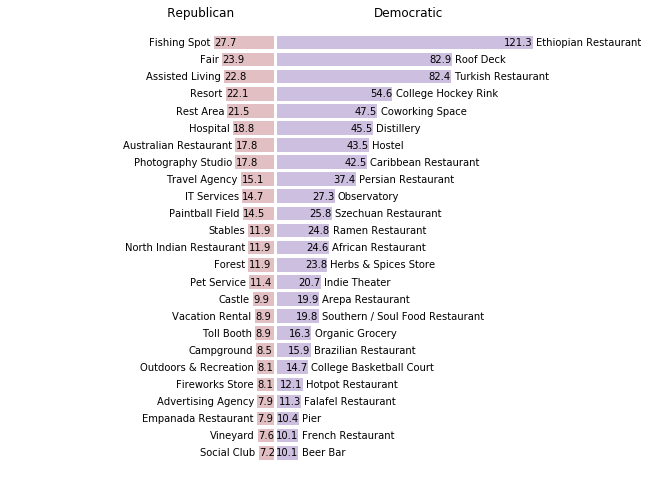

In [66]:
# configure figure
fig, axes = plt.subplots(ncols=2, sharey=True, figsize=[10,7])

# number of bars to plot
nbars = 25

# bar opacity
baralpha = 0.25

# Republican on left
axes[0].barh(range(0,nbars), 
             freq_norm[~np.isinf(freq_norm)][0:nbars].sort_values(), 
             align='center', 
             color='xkcd:crimson',
             alpha=baralpha
            )

# Democratic on right
axes[1].barh(range(0,nbars), 
             freq_norm_recip[~np.isinf(freq_norm_recip)][0:nbars].sort_values(), 
             align='center', 
             color='xkcd:indigo',
             alpha=baralpha
            )

# Text category labels: Republican
for i, v in enumerate(freq_norm[~np.isinf(freq_norm)][0:nbars].sort_values()):
    axes[0].text(v + 1.5, 
                 i - 0.2, 
                 freq_norm[~np.isinf(freq_norm)][0:nbars].sort_values().index[i], 
                 horizontalalignment='right',
                 color='black')

# Text category labels: Democratic
for i, v in enumerate(freq_norm_recip[~np.isinf(freq_norm_recip)][0:nbars].sort_values()):
    axes[1].text(v + 1.5, 
                 i - 0.2, 
                 freq_norm_recip[~np.isinf(freq_norm_recip)][0:nbars].sort_values().index[i], 
                 horizontalalignment='left',
                 color='black')
    
# Text value labels: Republican
for i, v in enumerate(freq_norm[~np.isinf(freq_norm)][0:nbars].sort_values()):
    axes[0].text(v - 0.1, 
                 i - 0.2, 
                 str(np.round(freq_norm[~np.isinf(freq_norm)][0:nbars].sort_values()[i],1)), 
                 horizontalalignment='left',
                 color='black')
    
# Text value labels: Democratic
for i, v in enumerate(freq_norm_recip[~np.isinf(freq_norm_recip)][0:nbars].sort_values()):
    axes[1].text(v - 0.1, 
                 i - 0.2, 
                 str(np.round(freq_norm_recip[~np.isinf(freq_norm_recip)][0:nbars].sort_values()[i],1)), 
                 horizontalalignment='right',
                 color='black')

# invert left chart
axes[0].invert_xaxis()

# titles
axes[0].set(title='                              Republican')
axes[1].set(title='Democratic')

# layout
for ax in axes.flat:
    ax.margins(0.03)
    ax.grid(True)
    
fig.tight_layout()
fig.subplots_adjust(wspace=0.01)

plt.yticks([])
axes[0].set_xticks(np.arange(0,121,20), minor=False) 
axes[1].set_xticks(np.arange(0,121,20), minor=False) 
axes[0].set_xticks([]) 
axes[1].set_xticks([]) 
# axes[0].set_xticklabels(np.arange(0,130,20), fontdict=None, minor=False)
# axes[1].set_xticklabels(np.arange(0,130,20), fontdict=None, minor=False)
axes[0].set_xticklabels([])
axes[1].set_xticklabels([])
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].spines['left'].set_visible(False)
axes[0].spines['bottom'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].spines['left'].set_visible(False)
axes[1].spines['bottom'].set_visible(False)
axes[0].grid(False)
axes[1].grid(False)
# axes[0].axis('off')
# axes[1].axis('off')

# save to file
plt.savefig('13_freqdiff_norm.png', bbox_inches = "tight")

plt.show()

This figure does a good job confirming the rural/urban voting stereotype. As noted, the most frequently occuring categories in Republican precincts align well with rural areas ('Fishing Spot', 'Rest Area', 'Stables', 'Forest', 'Campground', 'Outdoors & Recreation', etc.) And, on the Democratic side a variety of ethnic restaurants ('Ethiopian', 'Turkish', 'Brazilian', etc.) and quintessentially urban types of venues are observed ('Roof Deck', 'Coworking Space', 'Indie Theater', 'Organic Grocery'). 

#### Methodology & Results: Classification algorthim set-up

So, the venue category information has provided some insight into the nature of Democratic and Republican precincts in Ohio. Now, classification algorithms will be used to ascertain the power of the venue catoregy data alone to predict the election results of Ohio voting precincts. The classification algortihms to be tested are Decision Trees (DT), K-Nearest Neighbors (KNN), Support Vector Machines (SVM), and Logistic Regression (LR). Parametric studies will be done for all four classification algorthims and the best results, in terms of the Jaccard Similarity Score, will be used for further analysis in the following sections. It is beyond the scope of this work to provide details on the classification algorithms, but per usual, the sci-kit learn online User Guide and WikiPedia are very helpful.

But, first, the one-hot venue category information for all precincts must be split into training and testing datasets. (It should be noted explicitly that, unlike the preceding cluster data exploration work, the precinct election results are obviously **not** used in the feature set here. Rather, the precinct election results are the target category/classification data set.) Once these training/testing data sets have been created, they will be used to test each of the classification algorthims, without modification.

In [67]:
# Import and calculate Jaccard Similarity Score to be used for all algorithms
from sklearn.metrics import jaccard_similarity_score

# import accuray score (equal to jaccard_similarity_score function in this work)
from sklearn import metrics
from sklearn.metrics import accuracy_score

# Import f1-score to be used for all algorithms
from sklearn.metrics import classification_report

In [68]:
# find column indices for one-hot section of new df (do NOT include 'winner_binary')
j_start_class = df_merged.columns.get_loc("ATM")
j_end_class = df_merged.columns.get_loc("Zoo Exhibit")

# feature data set
X = df_merged.iloc[:,j_start_class:j_end_class+1].values

# target data set
y = df_merged["winner"]

# import library for train/test splitting
from sklearn.model_selection import train_test_split

# create training and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3)

In [69]:
# check
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(7206, 527)
(7206,)
(3089, 527)
(3089,)


#### Methodology & Results: Classification w/ Decision Tree

In [70]:
# import Decision Tree classifier
from sklearn.tree import DecisionTreeClassifier

# Create list of DecisionTreeClassifier parameter: 'criterion'
critval = ['gini', 'entropy']
ncrit = len(critval)
# print('ncrit =',ncrit)
# for ic, crit in enumerate(critval):
#     print(ic, crit)
    
# Allocate arrays for mean and standard deviation for each 'criterion' value
mean_acc = np.zeros((ncrit))
std_acc = np.zeros((ncrit))
 
# Loop over 'criterion' options
for ic, crit in enumerate(critval):
        
    # Train Model and Predict  
    precinctTree = DecisionTreeClassifier(criterion=crit, max_depth=4)
    precinctTree.fit(X_train,y_train)
    predTree = precinctTree.predict(X_test)
    
    # Calculate mean accuracy score and standard deviation
    mean_acc[ic] = metrics.accuracy_score(y_test, predTree)
    std_acc[ic] = np.std(predTree==y_test)/np.sqrt(predTree.shape[0])
#     print(ic, crit, mean_acc[ic], std_acc[ic])

# use best parameter configuration to create final model & report score
print('The best parameter(s) for the Decision Tree Classifier is/are:\n',critval[np.argmax(mean_acc)])
precinctTree = DecisionTreeClassifier(criterion=critval[np.argmax(mean_acc)], max_depth=4)
precinctTree.fit(X_train,y_train)
predTree = precinctTree.predict(X_test)

# Jaccard Similarity Score
print('Jaccard Similariy Score =',jaccard_similarity_score(y_test, predTree))

print("Train set Accuracy:", metrics.accuracy_score(y_train, precinctTree.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, predTree))

# f1-score report
print (classification_report(y_test, predTree))

The best parameter(s) for the Decision Tree Classifier is/are:
 gini
Jaccard Similariy Score = 0.8028488183878277
Train set Accuracy: 0.8075215098529004
Test set Accuracy:  0.8028488183878277
                           precision    recall  f1-score   support

 pres_16_donald_j_trump_r       0.87      0.85      0.86      2162
pres_16_hillary_clinton_d       0.66      0.70      0.68       927

                micro avg       0.80      0.80      0.80      3089
                macro avg       0.77      0.77      0.77      3089
             weighted avg       0.81      0.80      0.80      3089



The Decision Tree classifier is able to predict the 2016 Presidential election results of Ohio voting precincts with 80.2% accuracy.

#### Methodology & Results: Classification w/ K-Nearest Neighbors

The best parameter(s) for the KNN Classifier is/are:
 2


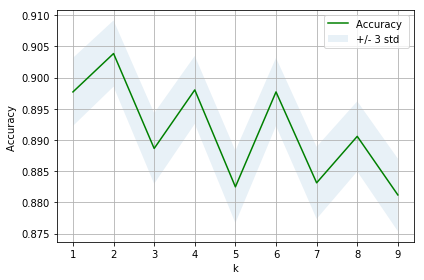

Jaccard Similariy Score = 0.8028488183878277
Train set Accuracy:  0.956563974465723
Test set Accuracy:  0.9038523794108125
                           precision    recall  f1-score   support

 pres_16_donald_j_trump_r       0.91      0.95      0.93      2162
pres_16_hillary_clinton_d       0.88      0.79      0.83       927

                micro avg       0.90      0.90      0.90      3089
                macro avg       0.90      0.87      0.88      3089
             weighted avg       0.90      0.90      0.90      3089



In [71]:
# Import KNN
from sklearn.neighbors import KNeighborsClassifier

# k-values to test...
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

# Loop over k-values
for n in range(1,Ks):
    
    # Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat_KNN = neigh.predict(X_test)
    
    # Calculate mean accuracy score and standard deviation    
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat_KNN)
    std_acc[n-1]=np.std(yhat_KNN==y_test)/np.sqrt(yhat_KNN.shape[0])

# use best parameter configuration to create final model & report score
print('The best parameter(s) for the KNN Classifier is/are:\n',np.argmax(mean_acc)+1)

# plot model accuracy as a function k
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3 std'))
plt.ylabel('Accuracy ')
plt.xlabel('k')
plt.tight_layout()
plt.grid()
plt.show()

# re-train Model and Predict w/ most accurate number of neighbors
n = mean_acc.argmax() + 1
neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
yhat_KNN = neigh.predict(X_test)

# Jaccard Similarity Score
print('Jaccard Similariy Score =',jaccard_similarity_score(y_test, predTree))

print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat_KNN))

# f1-score report
print (classification_report(y_test, yhat_KNN))

The KNN classifier is able to predict the 2016 Presidential election results of Ohio voting precincts with 90.4% accuracy.

#### Methodology & Results: Classification w/ Support Vector Machine

In [72]:
# Import SVM
from sklearn import svm

# SVM has four callable 'kernel' options: ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’
# ** & 'poly' can be further modified by the 'degree' parameter (default=3)

# Create list of SVM 'kernel' parameter
kernval = ['linear', 'poly', 'rbf', 'sigmoid']
nkern = len(kernval)

# Test different degree 'poly' kernels, not just the default degree=3...
ndegree = 10

# Allocate arrays for mean and standard deviation for each 'kernel' value
mean_acc = np.zeros((nkern))

# Loop over 'criterion' options
for ik, kern in enumerate(kernval):
    
    # Test 1-->ndegree different 'poly' kernels
    if (kern=='poly'):
                
        # loop over poly degrees
        for ideg in range(1,ndegree+1):
            
            # Train Model and Predict  
            svm_prec = svm.SVC(kernel=kern, degree=ideg, gamma='auto')
            svm_prec.fit(X_train, y_train)
            yhat_SVM = svm_prec.predict(X_test)

            # Calculate mean accuracy score and standard deviation & keep best fit so far
            if (ideg==1):
                mean_acc[ik] = metrics.accuracy_score(y_test, yhat_SVM)
            else:
                mean_acc[ik] = np.maximum(mean_acc[ik-1], metrics.accuracy_score(y_test, yhat_SVM))
        
    # Test all other non-'poly' kernels
    else:
        
        # Train Model and Predict  
        svm_prec = svm.SVC(kernel=kern, gamma='auto')
        svm_prec.fit(X_train, y_train)
        yhat_SVM = svm_prec.predict(X_test)
    
        # Calculate mean accuracy score and standard deviation
        mean_acc[ik] = metrics.accuracy_score(y_test, yhat_SVM)
        
# use best parameter configuration to create final model & report score
print('The best parameter(s) for the SVM Classifier is/are:\n',kernval[np.argmax(mean_acc)])

# re-train Model and Predict w/ optimal parameters
svm_prec = svm.SVC(kernel=kernval[np.argmax(mean_acc)], gamma='auto')
svm_prec.fit(X_train, y_train)
yhat_SVM = svm_prec.predict(X_test)        

# Jaccard Similarity Score
print('Jaccard Similariy Score =',jaccard_similarity_score(y_test, predTree))

print("Train set Accuracy:", metrics.accuracy_score(y_train, svm_prec.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat_SVM))

# f1-score report
print (classification_report(y_test, yhat_SVM))

The best parameter(s) for the SVM Classifier is/are:
 linear
Jaccard Similariy Score = 0.8028488183878277
Train set Accuracy: 0.7549264501804053
Test set Accuracy:  0.765943671090968
                           precision    recall  f1-score   support

 pres_16_donald_j_trump_r       0.75      0.99      0.86      2162
pres_16_hillary_clinton_d       0.89      0.25      0.39       927

                micro avg       0.77      0.77      0.77      3089
                macro avg       0.82      0.62      0.62      3089
             weighted avg       0.79      0.77      0.72      3089



The SVM classifier is able to predict the 2016 Presidential election results of Ohio voting precincts with 76.6% accuracy.

#### Methodology & Results: Classification w/ Logistic Regression

In [73]:
# Import LogisticRegression
from sklearn.linear_model import LogisticRegression

# LogisticRegression has many parameters. We will focus on regularization strength C, and solver:
# C = 0.001, 0.01, 0.1, 1.0, 10.0, 100.0
# solver = 'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'

# Create list of 'solver' parameter
solvval = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
nsolv = len(solvval)

# Test different regularization strengths 'C' (logistic)
regC = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]
nC = len(regC)

# Allocate arrays for mean and standard deviation for each 'kernel' value
mean_acc = np.zeros((nsolv,nC))
std_acc = np.zeros((nsolv,nC))
 
# Loop over 'solver' options
for isolv, solv in enumerate(solvval):
    
    # Loop over regularization strengths
    for iC, C in enumerate(regC):
        
        # Train Model and Predict  
        LR = LogisticRegression(C=C, solver=solv, max_iter=10000)
        LR.fit(X_train, y_train)
        yhat_LR = LR.predict(X_test)
    
        # Calculate mean accuracy score and standard deviation
        mean_acc[isolv,iC] = metrics.accuracy_score(y_test, yhat_LR)
        std_acc[isolv,iC] = np.std(yhat_LR==y_test)/np.sqrt(yhat_LR.shape[0])

# use best parameter configuration to create final model & report score
print('The best parameter(s) for the LR Classifier is/are:\n',solvval[0],'\n',regC[mean_acc.argmax()])
    
# re-train Model and Predict w/ optimum parametes
LR = LogisticRegression(C=regC[mean_acc.argmax()], solver=solvval[0], max_iter=10000)
LR.fit(X_train, y_train)
yhat_LR = LR.predict(X_test)
                               
# Jaccard Similarity Score
print('Jaccard Similariy Score =',jaccard_similarity_score(y_test, yhat_LR))

print("Train set Accuracy: ", metrics.accuracy_score(y_train, LR.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat_LR))

# f1-score report
print (classification_report(y_test, yhat_LR))

# # Import and calculate log-loss
# from sklearn.metrics import log_loss
# print('Log Loss =',log_loss(y_test, yhat_LR_prob))

The best parameter(s) for the LR Classifier is/are:
 newton-cg 
 10000.0
Jaccard Similariy Score = 0.8769828423438005
Train set Accuracy:  0.8942547876769359
Test set Accuracy:  0.8769828423438005
                           precision    recall  f1-score   support

 pres_16_donald_j_trump_r       0.90      0.93      0.91      2162
pres_16_hillary_clinton_d       0.82      0.76      0.79       927

                micro avg       0.88      0.88      0.88      3089
                macro avg       0.86      0.84      0.85      3089
             weighted avg       0.88      0.88      0.88      3089



The LR classifier is able to predict the 2016 Presidential election results of Ohio voting precincts with 87.7% accuracy.

#### Methodology & Results: Classification w/ Naive Bayes (Multinomial)

Since the features set is normalized one-hot, the values are continuous in the sense that they can take on any values between 0 and 1. However, any feature vector is actually a normalized discrete frequency count of the number of times that particular feature occurs in a given precinct. Therefore, the Multinomial Naive Bayes classifier is used.

In [96]:
# Import Naive Bayes (Gaussian)
from sklearn.naive_bayes import GaussianNB

# Train model and predict
gnb = GaussianNB()
gnb.fit(X_train, y_train)
yhat_gnb = gnb.predict(X_test)
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != yhat_gnb).sum()))

# Jaccard Similarity Score
print('Jaccard Similariy Score =',jaccard_similarity_score(y_test, yhat_gnb))

print("Train set Accuracy:", metrics.accuracy_score(y_train, gnb.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat_gnb))

# f1-score report
print (classification_report(y_test, yhat_gnb))

Number of mislabeled points out of a total 3089 points : 1236
Jaccard Similariy Score = 0.5998705082550987
Train set Accuracy: 0.6115736885928393
Test set Accuracy:  0.5998705082550987
                           precision    recall  f1-score   support

 pres_16_donald_j_trump_r       0.96      0.44      0.61      2162
pres_16_hillary_clinton_d       0.43      0.96      0.59       927

                micro avg       0.60      0.60      0.60      3089
                macro avg       0.70      0.70      0.60      3089
             weighted avg       0.80      0.60      0.60      3089



In [93]:
# Import Naive Bayes (Multinomial)
from sklearn.naive_bayes import MultinomialNB

# Train model and predict
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
yhat_mnb = mnb.predict(X_test)

# Jaccard Similarity Score
print('Jaccard Similariy Score =',jaccard_similarity_score(y_test, yhat_mnb))

print("Train set Accuracy:", metrics.accuracy_score(y_train, mnb.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat_mnb))

# f1-score report
print (classification_report(y_test, yhat_mnb))

# svm_prec = svm.SVC(kernel=kernval[np.argmax(mean_acc)], gamma='auto')
# svm_prec.fit(X_train, y_train)
# yhat_SVM = svm_prec.predict(X_test) 

# # Jaccard Similarity Score
# print('Jaccard Similariy Score =',jaccard_similarity_score(y_test, predTree))

# print("Train set Accuracy:", metrics.accuracy_score(y_train, svm_prec.predict(X_train)))
# print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat_SVM))

# # f1-score report
# print (classification_report(y_test, yhat_SVM))

Jaccard Similariy Score = 0.699902881191324
Train set Accuracy: 0.6937274493477658
Test set Accuracy:  0.699902881191324
                           precision    recall  f1-score   support

 pres_16_donald_j_trump_r       0.70      1.00      0.82      2162
pres_16_hillary_clinton_d       0.00      0.00      0.00       927

                micro avg       0.70      0.70      0.70      3089
                macro avg       0.35      0.50      0.41      3089
             weighted avg       0.49      0.70      0.58      3089



/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Methodology & Results: Classification w/ Random Forest

In [99]:
# Import random forest
from sklearn.ensemble import RandomForestClassifier

# Train model and predict
rf = RandomForestClassifier(n_estimators = 1000, random_state=0)
rf.fit(X_train, y_train)
#print(rf.feature_importances_)
yhat_rf = rf.predict(X_test)

# # Train model and predict
# mnb = MultinomialNB()
# mnb.fit(X_train, y_train)
# yhat_mnb = mnb.predict(X_test)

# Jaccard Similarity Score
print('Jaccard Similariy Score =',jaccard_similarity_score(y_test, yhat_rf))

print("Train set Accuracy:", metrics.accuracy_score(y_train, rf.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat_rf))

# f1-score report
print (classification_report(y_test, yhat_rf))

Jaccard Similariy Score = 0.9219812236969893
Train set Accuracy: 0.9994449070219261
Test set Accuracy:  0.9219812236969893
                           precision    recall  f1-score   support

 pres_16_donald_j_trump_r       0.93      0.96      0.95      2162
pres_16_hillary_clinton_d       0.90      0.83      0.86       927

                micro avg       0.92      0.92      0.92      3089
                macro avg       0.92      0.90      0.90      3089
             weighted avg       0.92      0.92      0.92      3089



#### Methodology & Results: Feature selection

Although this is a pretty small data set (roughly 10,000 precincts with roughly 500 features each), there still may be some merit in examining the feature set for redundant and/or irrelevant features. These features can be omitted from the analysis, which can make results easier to understand, reduce computational times (for larger data sets in particular), and limit reduce model variance (overfitting to training data).

#### Methodology & Results: Feature selection by food-only related venues

There are many ways to employ feature selection. The most basic and blunt-force approach is to manually select a subset of features. In this work, two manual selections are made and tested. The first is food-only related venue categories. The second is all non-food related venue categories. Both subsets are used with the best performing classification algorithm (k-nearest neighbors w/ k=2), and the results are shown below.

In [74]:
# make copy of full dataframe
df_food = df_merged

# find column indices for one-hot section of new df
jf_start = df_food.columns.get_loc("ATM")
jf_end = df_food.columns.get_loc("Zoo Exhibit")

colNames = df_food.columns[df_food.columns.str.contains(pat = "Restaurant|BBQ|Bagel|Bakery|Breakfast|Bistro|Tea|Bar|Beer|Brewery|Buffet|Burger|"
           "Burrito|Butcher|Cafeteria|Café\|Cafe|Candy|Cheese|Chocolate|Coffee|Convenience"
           "Cupcake|Deli|Bodega|Dessert|Dim Sum|Diner|Donut|Farm|Market|Fast Food|Fish|"
           "Food|Drink|Chicken|Yogurt|Fruit|Vegetable|Gastropub|Gourmet|Grocery|Hot Dog|"
           "Ice Cream|Pub|Juice|Liquor|Noodle|Pie|Pizza|Poke|Salad|Sandwich|Smoothie|Snack|"
           "Soup|Speakeasy|Steakhouse|Supermarket|Taco|Vineyard|Wine|Winery|Wings")]

# create dataframe of one-hot food-only features
food_onehot = df_food[colNames]

# split reduced feature set into new training and testing datasets
Xf = food_onehot.values
yf = df_merged["winner"]
Xf_train, Xf_test, yf_train, yf_test = train_test_split(Xf, yf, test_size=0.3, random_state=3)

# apply KNN w/ k=2
n = 2
neigh_food = KNeighborsClassifier(n_neighbors = n).fit(Xf_train,yf_train)
yhat_KNN_food = neigh_food.predict(Xf_test)

# results
print("Train set Accuracy: ", metrics.accuracy_score(yf_train, neigh_food.predict(Xf_train)))
print("Test set Accuracy: ", metrics.accuracy_score(yf_test, yhat_KNN_food))
print (classification_report(yf_test, yhat_KNN_food))

Train set Accuracy:  0.9537885095753539
Test set Accuracy:  0.8967303334412431
                           precision    recall  f1-score   support

 pres_16_donald_j_trump_r       0.90      0.96      0.93      2162
pres_16_hillary_clinton_d       0.88      0.76      0.81       927

                micro avg       0.90      0.90      0.90      3089
                macro avg       0.89      0.86      0.87      3089
             weighted avg       0.90      0.90      0.89      3089



The KNN classifier with the full feature set had a test set accuracy of 90.4%.

The KNN classifier with the food-only feature set had a test set accuracy of 89.7%. So, only a small loss in accuracy is observed.

#### Methodology & Results: Feature selection by non-food related venues

In [75]:
# make copy 
df_notfood = df_merged

# generate column names of venue categories that are NOT food related
colNamesNot = df_notfood.iloc[0:1,jf_start:jf_end+1].columns[~df_notfood.iloc[0:1,jf_start:jf_end+1].columns.str.contains(pat = "Restaurant|BBQ|Bagel|Bakery|Breakfast|Bistro|Tea|Bar|Beer|Brewery|Buffet|Burger|"
           "Burrito|Butcher|Cafeteria|Café\|Cafe|Candy|Cheese|Chocolate|Coffee|Convenience"
           "Cupcake|Deli|Bodega|Dessert|Dim Sum|Diner|Donut|Farm|Market|Fast Food|Fish|"
           "Food|Drink|Chicken|Yogurt|Fruit|Vegetable|Gastropub|Gourmet|Grocery|Hot Dog|"
           "Ice Cream|Pub|Juice|Liquor|Noodle|Pie|Pizza|Poke|Salad|Sandwich|Smoothie|Snack|"
           "Soup|Speakeasy|Steakhouse|Supermarket|Taco|Vineyard|Wine|Winery|Wings")]

# one-hot df of all NON-food related venue categories
notfood_onehot = df_notfood[colNamesNot]

# split reduced feature set into new training and testing datasets
Xnf = notfood_onehot.values
ynf = df_merged["winner"]
Xnf_train, Xnf_test, ynf_train, ynf_test = train_test_split(Xnf, ynf, test_size=0.3, random_state=3)

# apply KNN w/ k=2
n = 2
neigh_notfood = KNeighborsClassifier(n_neighbors = n).fit(Xnf_train,ynf_train)
yhat_KNN_notfood = neigh_notfood.predict(Xnf_test)

# results
print("Train set Accuracy: ", metrics.accuracy_score(ynf_train, neigh_notfood.predict(Xnf_train)))
print("Test set Accuracy: ", metrics.accuracy_score(ynf_test, yhat_KNN_notfood))
print (classification_report(ynf_test, yhat_KNN_notfood))

Train set Accuracy:  0.9571190674437968
Test set Accuracy:  0.9038523794108125
                           precision    recall  f1-score   support

 pres_16_donald_j_trump_r       0.91      0.96      0.93      2162
pres_16_hillary_clinton_d       0.89      0.78      0.83       927

                micro avg       0.90      0.90      0.90      3089
                macro avg       0.90      0.87      0.88      3089
             weighted avg       0.90      0.90      0.90      3089



The KNN classifier with the full feature set had a test set accuracy of 90.4%.

The KNN classifier with the non-food feature set *also* had a test set accuracy of 90.4%. So, it would appear that food-only, non-food, and full feature sets all produce very similar results. Perhaps, it could be said that the food-only features are redundant to the non-food features. But, beyond the data exploration already done in previous sections, there is not much more manual exploration of the venue categories to do. However, other techniques can be leveraged to give some insight into which venue categories are most influential on the classification model's predictive capability.

#### Methodology & Results: Feature selection by Correlation Feature Analysis (CFA)

This methodology is based on the idea that features that are worth keeping are highly correlated with the target classification category, but not with other features. In other words, only keep features that have a big effect on the classification, and eliminate features that only have a big effect on other features, since they are redundant.

In [76]:
# create dataframe with one-hot features 
Xycorr = df_merged.iloc[:,jf_start:jf_end+1]

# add binary 0/1 classification column
Xycorr['winner_binary'] = df_merged['winner_binary']

# create correlation matrix
corrmatrix = Xycorr.corr()

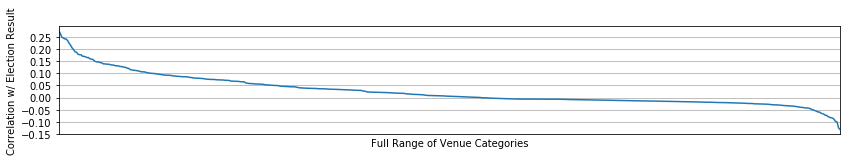

In [77]:
# plot correlation of the classification category w/ all other features
fig = corrmatrix.iloc[-1,:].sort_values(ascending=False)[1:].plot(kind='line', figsize=[14,2])
plt.grid(True)
plt.xticks([])
fig.set_xlabel('Full Range of Venue Categories')
fig.set_ylabel('Correlation w/ Election Result')
fig.xaxis.tick_bottom()
ax = fig.set_yticks(np.arange(-0.15,0.3,0.05))
plt.savefig('14_corr_election.png', bbox_inches = "tight")
plt.show()

Since there are so many features, this plot does not help much. Another way to get some insight into the correlation matrix is to produce a heatmap figure. However, since we have over 500 features (the correlation matrix is [528,528]), it will be difficult to see what's going on. Therefore, two (50,50) heatmaps are generated, focusing on the highest absolute correlation values at each end of the figure above.

In [78]:
# import library to generate heatmap of correlation matrix
import seaborn as sns

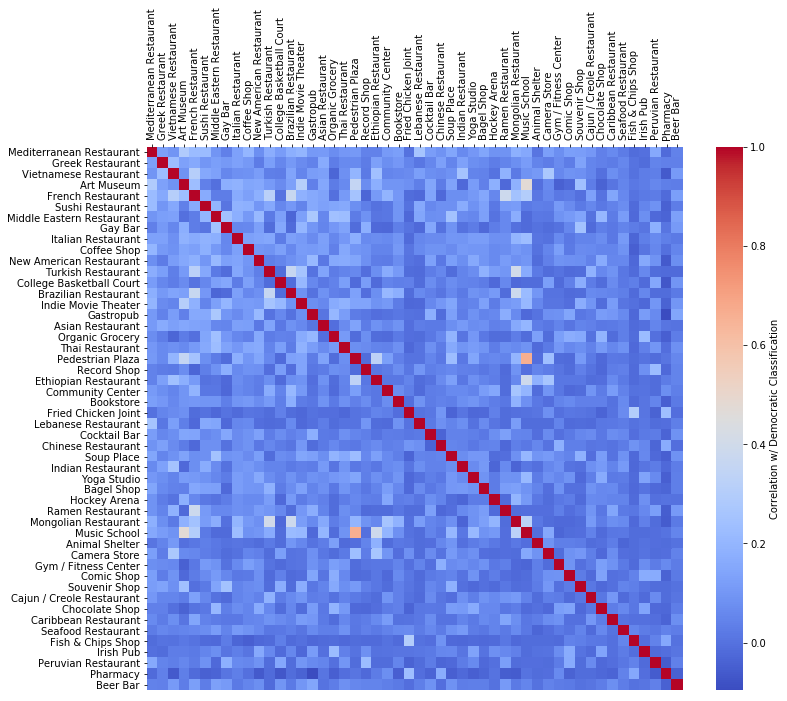

In [79]:
# Top 50 Venue Categories Correlated w/ Democratic Precincts
plt.figure(figsize=(12,10))
fig = sns.heatmap(corrmatrix.sort_values(by=['winner_binary'], axis=0, ascending=False).sort_values(by=['winner_binary'], axis=1, ascending=False).iloc[1:51,1:51], 
                  cbar_kws={'label': 'Correlation w/ Democratic Classification'},
                  cmap='coolwarm')
fig.xaxis.tick_top()
plt.xticks(rotation=90)
plt.savefig('15_heatmap_D.png', bbox_inches = "tight")
plt.show()

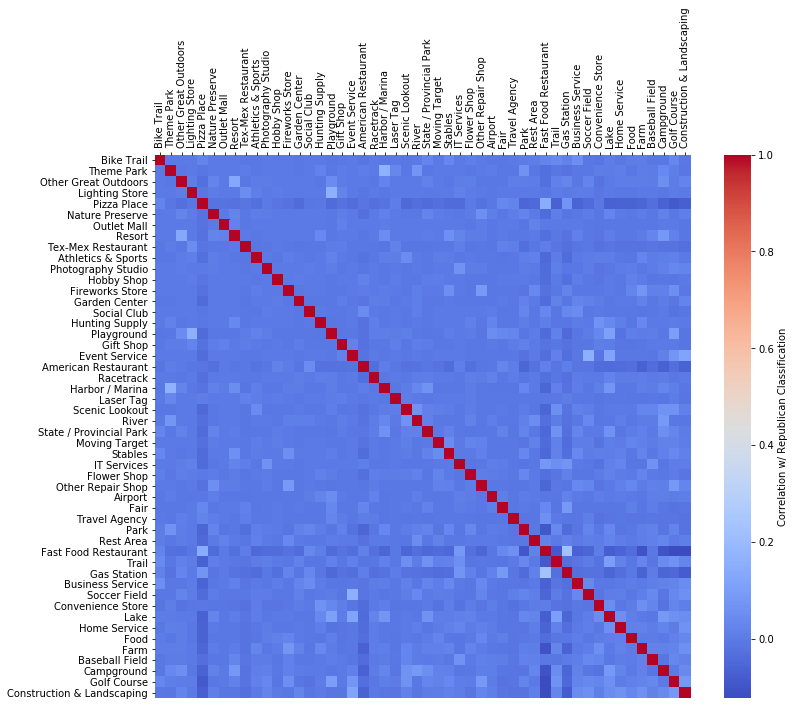

In [80]:
# Top 50 Venue Categories Correlated w/ Republican Precincts
plt.figure(figsize=(12,10))
fig = sns.heatmap(corrmatrix.sort_values(by=['winner_binary'], axis=0, ascending=False).sort_values(by=['winner_binary'], axis=1, ascending=False).iloc[-50:,-50:], 
                  cbar_kws={'label': 'Correlation w/ Republican Classification'},
                  cmap='coolwarm')
fig.xaxis.tick_top()
plt.xticks(rotation=90)
plt.savefig('16_heatmap_R.png', bbox_inches = "tight")
plt.show()

The heatmaps show some higher correlation values between features, which could be be filtered out of the feature set by setting a correlation threshold. Then, only features which have low correlation with all other features would remain. Additionally, the correlation matrix can provide more insight on the nature of the Democratic and Republican precincts. The following code produces a figure that better visualizes which venue categories are most highly correlated with each precinct classification.

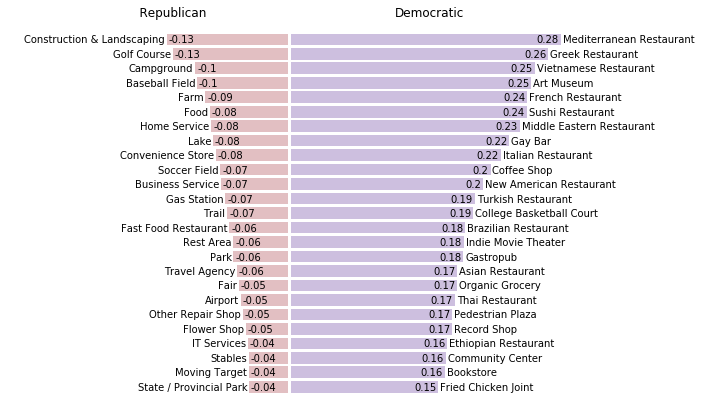

In [81]:
# plot top 50 most venue categories correlated with both Dem and Rep precincts
fig, axes = plt.subplots(ncols=2, sharey=True, figsize=[10,7])

# number of bars to plot
nbars = 25

# bar opacity
baralpha = 0.25

# dataframes to be plotted
corr_rep = corrmatrix.iloc[-1,:].sort_values(ascending=False)[-nbars:]
corr_dem = corrmatrix.iloc[-1,:].sort_values(ascending=False)[1:nbars+1].sort_values()

# Republican on left
axes[0].barh(range(0,nbars), 
             corr_rep, 
             align='center', 
             color='xkcd:crimson',
             alpha=baralpha
            )

# Democratic on right
axes[1].barh(range(0,nbars), 
             corr_dem, 
             align='center', 
             color='xkcd:indigo',
             alpha=baralpha
            )

# Text category labels: Republican
for i, v in enumerate(corr_rep):
    axes[0].text(v - 0.002, 
                 i - 0.25, 
                 corr_rep.index[i], 
                 horizontalalignment='right',
                 color='black')

# Text category labels: Democratic
for i, v in enumerate(corr_dem):
    axes[1].text(v + 0.002, 
                 i - 0.25, 
                 corr_dem.index[i], 
                 horizontalalignment='left',
                 color='black')
    
# Text value labels: Republican
for i, v in enumerate(corr_rep):
    axes[0].text(v + 0.002, 
                 i -0.25, 
                 str(np.round(corr_rep[i],2)), 
                 horizontalalignment='left',
                 color='black')
    
# Text value labels: Democratic
for i, v in enumerate(corr_dem):
    axes[1].text(v - 0.002, 
                 i - 0.25, 
                 str(np.round(corr_dem[i],2)), 
                 horizontalalignment='right',
                 color='black')

# titles
axes[0].set(title='            Republican')
axes[1].set(title='Democratic')

# layout
for ax in axes.flat:
    ax.margins(0.03)
    ax.grid(True)
    
#fig.tight_layout()
fig.subplots_adjust(wspace=0.01)

plt.yticks([])
axes[0].set_xticks(np.arange(-0.3,0,0.1), minor=False) 
axes[1].set_xticks(np.arange(0,0.3,0.1), minor=False) 
axes[0].set_xticks([]) 
axes[1].set_xticks([]) 
axes[0].set_xticklabels([])
axes[1].set_xticklabels([])
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].spines['left'].set_visible(False)
axes[0].spines['bottom'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].spines['left'].set_visible(False)
axes[1].spines['bottom'].set_visible(False)
axes[0].grid(False)
axes[1].grid(False)

plt.savefig('17_corrcomp.png', bbox_inches = "tight")

plt.show()

This figure is very similar to the figure comparing venue category frequency in Democratic and Republican precincts. The figure shows the venue categories most highly correlated with Republican precincts (left hand side) and Democratic precincts (right hand side). The venues most correlated with Republican precincts do fit the rural stereotype: 'Construction & Landscaping', 'Campground', 'Farm', 'Lake'. Although some of the categories are ambiguous. The venues most closely correlated with Democratic precincts fit the urban stereotype. In the top ten are a variety of ethnic restaurant (including 'French Restaurant'), 'Art Museum', and 'Gay Bar'. So, it's pretty safe to say that Republican precincts are well approximated by the rural designation, and Democratic precincts are well described by the urban designation.

Rather than continue with this CFA, and somewhat bluntly filtering features with a correlation threshold, the following section will instead employ a more elegant approach.

#### Methodology & Results: Feature selection by Chi-Squared Independence Test

The Chi-Squared test is employed here to select the *n* "best" features from the feature set. This approach is tested for a few different values of n (n=20,50,100). Each of these reduced feature sets are used with the KNN algorithm and the accuracies are compared. The idea here is to reduce the number of features as much as possible, while miitigating the effect on accuracy.

In [82]:
# import library for feature selection
from sklearn.feature_selection import SelectKBest, chi2

In [83]:
# do this in parts to isolate the "selector" allowing us to retrieve feature names
selector20 = SelectKBest(chi2, k=20)
selector20.fit(X, y)
X_chi20 = selector20.transform(X)

# get names of features (venue categories) that were deemed "best"
top20venues = df_merged.iloc[:,j_start_class:j_end_class+1].columns[selector20.get_support(indices=True)].tolist()

# create training and testing data sets
Xchi20_train, Xchi20_test, ychi20_train, ychi20_test = train_test_split(X_chi20, y, test_size=0.3, random_state=3)

# run KNN on new feature set
n = 2
neigh_chi20 = KNeighborsClassifier(n_neighbors = n).fit(Xchi20_train,ychi20_train)
yhat_KNN_chi20 = neigh_chi20.predict(Xchi20_test)

# results
print("Train set Accuracy: ", metrics.accuracy_score(ychi20_train, neigh_chi20.predict(Xchi20_train)))
print("Test set Accuracy: ", metrics.accuracy_score(ychi20_test, yhat_KNN_chi20))
print (classification_report(ychi20_test, yhat_KNN_chi20))

Train set Accuracy:  0.9023036358590064
Test set Accuracy:  0.8297183554548397
                           precision    recall  f1-score   support

 pres_16_donald_j_trump_r       0.83      0.95      0.89      2162
pres_16_hillary_clinton_d       0.82      0.56      0.66       927

                micro avg       0.83      0.83      0.83      3089
                macro avg       0.83      0.75      0.77      3089
             weighted avg       0.83      0.83      0.82      3089



In [84]:
# find and use top 50 features
selector50 = SelectKBest(chi2, k=50)
selector50.fit(X, y)
X_chi50 = selector50.transform(X)
top50venues = df_merged.iloc[:,j_start_class:j_end_class+1].columns[selector50.get_support(indices=True)].tolist()
Xchi50_train, Xchi50_test, ychi50_train, ychi50_test = train_test_split(X_chi50, y, test_size=0.3, random_state=3)
n = 2
neigh_chi50 = KNeighborsClassifier(n_neighbors = n).fit(Xchi50_train,ychi50_train)
yhat_KNN_chi50 = neigh_chi50.predict(Xchi50_test)

print("Train set Accuracy: ", metrics.accuracy_score(ychi50_train, neigh_chi50.predict(Xchi50_train)))
print("Test set Accuracy: ", metrics.accuracy_score(ychi50_test, yhat_KNN_chi50))
print(jaccard_similarity_score(ychi50_test, yhat_KNN_chi50))
print (classification_report(ychi50_test, yhat_KNN_chi50))

Train set Accuracy:  0.8960588398556758
Test set Accuracy:  0.8484946584655229
0.8484946584655229
                           precision    recall  f1-score   support

 pres_16_donald_j_trump_r       0.89      0.90      0.89      2162
pres_16_hillary_clinton_d       0.75      0.73      0.74       927

                micro avg       0.85      0.85      0.85      3089
                macro avg       0.82      0.82      0.82      3089
             weighted avg       0.85      0.85      0.85      3089



In [85]:
# find and use top 100 features
selector100 = SelectKBest(chi2, k=100)
selector100.fit(X, y)
X_chi100 = selector100.transform(X)
top100venues = df_merged.iloc[:,j_start_class:j_end_class+1].columns[selector100.get_support(indices=True)].tolist()
Xchi100_train, Xchi100_test, ychi100_train, ychi100_test = train_test_split(X_chi100, y, test_size=0.3, random_state=3)
n = 2
neigh_chi100 = KNeighborsClassifier(n_neighbors = n).fit(Xchi100_train,ychi100_train)
yhat_KNN_chi100 = neigh_chi100.predict(Xchi100_test)

print("Train set Accuracy: ", metrics.accuracy_score(ychi100_train, neigh_chi100.predict(Xchi100_train)))
print("Test set Accuracy: ", metrics.accuracy_score(ychi100_test, yhat_KNN_chi100))
print(jaccard_similarity_score(ychi100_test, yhat_KNN_chi100))
print (classification_report(ychi100_test, yhat_KNN_chi100))

Train set Accuracy:  0.951706910907577
Test set Accuracy:  0.9035286500485594
0.9035286500485594
                           precision    recall  f1-score   support

 pres_16_donald_j_trump_r       0.91      0.96      0.93      2162
pres_16_hillary_clinton_d       0.90      0.77      0.83       927

                micro avg       0.90      0.90      0.90      3089
                macro avg       0.90      0.86      0.88      3089
             weighted avg       0.90      0.90      0.90      3089



The KNN classifier with the full feature set had a test set accuracy of 90.4%.

The chi-squared test results of n=(20,50,100) produced KNN accuracies of 83.0%, 84.8%, and 90.4%, respectively. So, the chi-squared test reduced the feature set from n=528 down to n=100 while retaining a model prediction accuracy of 90%. Exploration of these results could help to improve the model. 

In [86]:
# create dataframe w/ ytest and ypred to sort them together...
df_ytestpred = ychi100_test.to_frame(name='ychi100_test')

# add column for predicted results
df_ytestpred['yhat_KNN_chi100'] = yhat_KNN_chi100

# create dataframe of only precincts that were in the testing dataset
df_testvals = df_merged.loc[df_merged['Precinct_ID'].isin(ychi100_test.index)].copy()

# add column with prediction...
df_testvals['winner_predicted'] = df_ytestpred['yhat_KNN_chi100']

# create column boolean if prediction was correct
df_testvals['pred_tf'] = np.where(df_testvals['winner']==df_testvals['winner_predicted'], True, False)

# dataframe of precincts that were INCORRECTLY predicted
df_fpred = df_testvals[~df_testvals['pred_tf']]

# dataframes of precincts that were incorrectly predicted for Trump and Clinton, respectively
df_f_trump = df_fpred[df_fpred['winner_predicted']=='pres_16_donald_j_trump_r']
df_f_clinton = df_fpred[df_fpred['winner_predicted']=='pres_16_hillary_clinton_d']

# find column indices for one-hot section of new df
j_start = df_fpred.columns.get_loc("ATM")
j_end = df_fpred.columns.get_loc("Zoo Exhibit")

# create one-hot dataframes for each
df_f_trump_onehot = df_f_trump.iloc[:,j_start:j_end+1]
df_f_clinton_onehot = df_f_clinton.iloc[:,j_start:j_end+1]

# sum over each venue category
df_f_trump_sum = df_f_trump_onehot.sum(axis=0)
df_f_clinton_sum = df_f_clinton_onehot.sum(axis=0)
df_f_trump_sum.sort_values(ascending=False, inplace=True)
df_f_clinton_sum.sort_values(ascending=False, inplace=True)

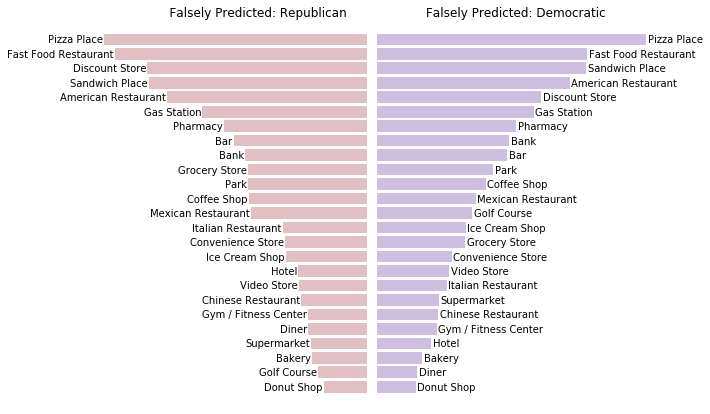

In [87]:
# plot top 50 most venue categories correlated with both Dem and Rep precincts
fig, axes = plt.subplots(ncols=2, sharey=True, figsize=[10,7])

# number of bars to plot
nbars = 25

# bar opacity
baralpha = 0.25

# dataframes to be plotted
false_rep = df_f_trump_sum[0:nbars].sort_values(ascending=True)
false_dem = df_f_clinton_sum[0:nbars].sort_values(ascending=True)

# Republican on left
axes[0].barh(range(0,nbars), 
             false_rep, 
             align='center', 
             color='xkcd:crimson',
             alpha=baralpha
            )

# Democratic on right
axes[1].barh(range(0,nbars), 
             false_dem, 
             align='center', 
             color='xkcd:indigo',
             alpha=baralpha
            )

# Text category labels: Republican
for i, v in enumerate(false_rep):
    axes[0].text(v + 0.05, 
                 i - 0.25, 
                 false_rep.index[i], 
                 horizontalalignment='right',
                 color='black')

# Text category labels: Democratic
for i, v in enumerate(false_dem):
    axes[1].text(v + 0.03, 
                 i - 0.25, 
                 false_dem.index[i], 
                 horizontalalignment='left',
                 color='black')
    
# # Text value labels: Republican
# for i, v in enumerate(false_rep):
#     axes[0].text(v + 0.002, 
#                  i -0.25, 
#                  str(np.round(false_rep[i],2)), 
#                  horizontalalignment='left',
#                  color='black')
    
# # Text value labels: Democratic
# for i, v in enumerate(false_dem):
#     axes[1].text(v - 0.002, 
#                  i - 0.25, 
#                  str(np.round(false_dem[i],2)), 
#                  horizontalalignment='right',
#                  color='black')

# titles
axes[0].set(title='            Falsely Predicted: Republican')
axes[1].set(title='Falsely Predicted: Democratic')

# layout
for ax in axes.flat:
    ax.margins(0.03)
    ax.grid(True)
    
#fig.tight_layout()
fig.subplots_adjust(wspace=0.01)

plt.yticks([])
axes[0].set_xticks(np.arange(-0.3,0,0.1), minor=False) 
axes[1].set_xticks(np.arange(0,0.3,0.1), minor=False) 
axes[0].set_xticks([]) 
axes[1].set_xticks([]) 
axes[0].set_xticklabels([])
axes[1].set_xticklabels([])
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].spines['left'].set_visible(False)
axes[0].spines['bottom'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].spines['left'].set_visible(False)
axes[1].spines['bottom'].set_visible(False)
axes[0].grid(False)
axes[1].grid(False)

axes[0].invert_xaxis()

plt.savefig('17X_falsecomp.png', bbox_inches = "tight")

plt.show()

It's easy to see why the model incorrectly predicted the outcomes for these groups. The categories and their frequency are very similar in both categories. Perhaps, in these cases, the Foursquare data is not sufficient, and othere types of data about the precincts would help  to differenetiate them. For now, the model will remain unchanged.

#### Methodology & Results: WordCloud visualization

It's fair to say that the top 100 venues produced by the chi-squared test are good indicators of the way an Ohio precinct voted in the 2016 Presidential election. As the previous section shows, inspection of the falsely predicted precincts did not yield any obvious clues to the deficiencies in the model. Therefore, to better visualize the final results of the model, a WordCloud figure is generated. The top 25 venue categories most highly correlated with the election results are are color-coded (Democratic=blue, Republican=red). The remaining venue categories are colored black.

In [88]:
# import libraries
from wordcloud import WordCloud
from PIL import Image 

In [89]:
# create Series to match venue categores with election results (based on correlation)
venue_colors = corrmatrix.iloc[-1,0:-1].sort_values(ascending=False)
venue_colors[venue_colors>=0] = 'blue'
venue_colors[~(venue_colors=='blue')] = 'red'
venue_colors.iloc[25:-25] = 'black'

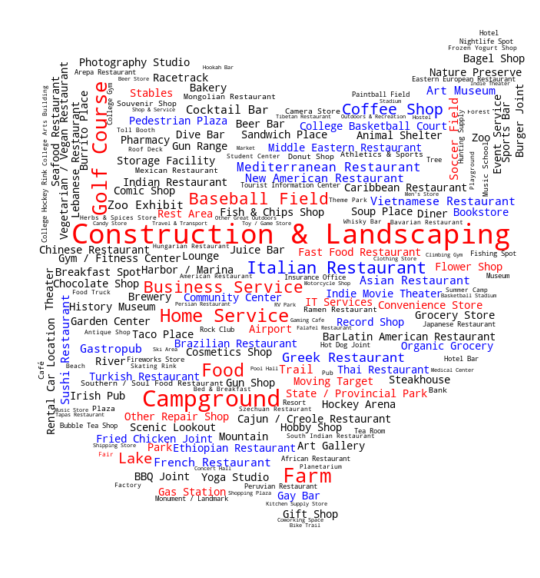

In [91]:
# create dataframe of chi2 values for all venue categories (to be used for wordcloud)
df_chi2_all = pd.DataFrame(chi2(X, y)[0][:], columns=['chi2'])
chi2_allvenues = df_merged.iloc[:,j_start_class:j_end_class+1].columns[:].tolist()
df_chi2_all.insert(loc=0, column='venue_category', value=chi2_allvenues)

# create dictionary of venue category (key) and chi2 values
dall = {}
for index, row in df_chi2_all.iterrows():
    dall[row['venue_category']] = row['chi2']
    
# create a single string of all venue categories (separated by commas)
venue_string = ','.join('{}'.format(key) for key, val in dall.items())
    
# load Ohio image
ohio_mask = np.array(Image.open("ohio_border.jpg"))

# customer color function mapping venue category to election result (D/R)
def color_func(word, *args, **kwargs):
    color = venue_colors[word]
    return color
 
# Make the figure
wordcloud = WordCloud(mask=~ohio_mask,
                      background_color="white",
                      color_func=color_func
                     )    
wordcloud.generate_from_frequencies(frequencies=dall)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.savefig('18_oh_wordcloud.png', bbox_inches = "tight")
plt.show()

## Conclusion

In this work, the 2016 Presidential election results from Ohio voting precincts were explored.  The types of businesses and services in those precincts were used in conjunction with the voting data to do the analysis. Using clustering and classification machine-learning techniques on the data yield a couple key results. First, the stereotype that rural area vote Republican and urban area vote Democratic was confirmed. One sub-cluster of Republican precincts was dominated by 'Construction & Landscaping' businesses, and not much else. These precincts could be considered ultra-rural. Classification analysis yielded further insight into the divide between Democratic and Republican precincts. As expected, venues/businesses most closely correlated with Republican precincts tended toward the rural: landscaping, golf courses, campgrounds, farms, lakes, trails, parks, rest areas, etc. Venues/businesses most closely correlated with Democratic precincts included the stereotypically urban: all sorts of ethnic restaurants (including French), coworking spaces, indie theaters, organic groceries, and gay bars. But, ultimately the real power of this data lies in its ability to predict voting patterns. Using the k-nearest neighbors (KNN) classifier, the venue/businesses in a precinct can predict the voting habits of that precinct with about 90% accuracy. Of course, there are some caveats to that number. The venue/business information from Foursquare may not be complete or accurate. Additionally, although the election results were from 2016, the venue/business data was source in 2019. It's possible that venue data from 2016 would be produce a more accurate model. Finally, it would be worth applying this model to other states in midwest and on the coasts, to see if the voting patterns in Ohio are at all applicable elsewhere in the county. But, ultimately, the true power of this model won't be known until the next Presidential election in 2020.